### Features of this notebook
1. Custom Tokenizer
2. One Cyle LR


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/END/Transformer

/content/drive/MyDrive/END/Transformer


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Picasso')

# Imports

In [277]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.data import Field, BucketIterator, Example, Dataset

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from main_engine import lr_finder, schedulers
import spacy
import numpy as np
import pandas as pd
import re
from spacy.tokenizer import Tokenizer
import random
import math
import time
from sklearn.model_selection import train_test_split
import pygments
from pygments.lexers import PythonLexer
import seaborn as sns

In [5]:
# Setting Random Seeds
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


# Data Preprocessing

In [7]:
lines = []
with open('english_python_data_corrected.txt', encoding='utf-8') as f:
    for counter, line in enumerate(f):
            lines.append(line)
#Removing comments  
comment_re = re.compile(r'#\s*\dx\d\s*matrix|#\s*result|#\s*iterate|#\s*initialize|#\s*Driver|#\s*This function|#\s*Iterate', 
                        re.IGNORECASE)
lines = [x for x in lines if re.search(comment_re, x) is None]

example_start_id = [counter for counter,_ in enumerate(lines) if (_.startswith("#") or _.startswith(" #")) and (lines[counter-1].strip() == '')]
training_examples = []
for num, idx in enumerate(example_start_id):
    if idx != example_start_id[-1]:
        example_dict = {}
        example = lines[example_start_id[num]:example_start_id[num+1]]
        if (re.search(r"#\s*\d", example[0], re.IGNORECASE)) and (re.search(r"#", example[1], re.IGNORECASE)) is not None:
                    example_dict['ques_prompt'] = example[1].strip()
                    example_dict['source_code'] = "".join(example[2:]).strip()
        elif re.search(r'#\s*In\[\d*\]', "".join(example), re.IGNORECASE) is not None:
            continue
        else:
            example_dict['ques_prompt'] = example[0].strip()
            example_dict['source_code'] = "".join(example[1:]).strip()
        training_examples.append(example_dict)
    else:
        example_dict = {}
        example = lines[example_start_id[num]:]
        example_dict['ques_prompt'] = example[0].strip()
        example_dict['source_code'] = "".join(example[1:]).strip()
        training_examples.append(example_dict)

In [8]:
full_data = pd.DataFrame(training_examples)
# Dropping examples where length of code was greater than 250 characters
len_filter = full_data['source_code'].apply(lambda x:len(x) > 250)
full_data.drop(len_filter[len_filter == True].index.tolist(), inplace = True, axis = 0)
full_data.reset_index(drop = True, inplace = True)
full_data['ques_prompt'] = full_data['ques_prompt'].apply(lambda x:re.sub(r'\d*', '', x))
full_data['ques_prompt'] = full_data['ques_prompt'].apply(lambda x:re.sub(r'(#\s)+', '', x))
full_data.columns = ['src', 'trg']

In [9]:
full_data.head()

,src,trg
0,write a python program to add two numbers,num1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\npri...
1,write a python function to add two user provid...,"def add_two_numbers(num1, num2):\n sum = nu..."
2,write a program to find and print the largest ...,num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 >= n...
3,write a program to find and print the smallest...,num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 <= n...
4,Write a python function to merge two given lis...,"def merge_lists(l1, l2):\n return l1 + l2"


In [10]:
# Loading spacy language models for tokenization
en_tokenizer = spacy.load('en')

# Custom Tokenization

In [11]:
lexer = PythonLexer()
def tokenize_py(text):
    """
    Tokenizes Python text from a string into a list of tokens
    """
    tokens_texts = lexer.get_tokens(text)
    tokens_texts = [i[1] for i in tokens_texts if i[0] != pygments.token.Comment.Single]
    return tokens_texts

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of tokens
    """
    return [tok.text for tok in en_tokenizer.tokenizer(text)]

In [12]:
# Let's test our custom tokenizer
idx = 1
print(f'Target Sentence :\n{full_data.iloc[idx, 1]}\n')
print(f'Tokens : {tokenize_py(full_data.iloc[idx, 1])}\n',)
print(f'Reconstructed sentence from Tokens : \n{"".join(tokenize_py(full_data.iloc[idx, 1]))}\n')

Target Sentence :
def add_two_numbers(num1, num2):
    sum = num1 + num2
    return sum

Tokens : ['def', ' ', 'add_two_numbers', '(', 'num1', ',', ' ', 'num2', ')', ':', '\n', '    ', 'sum', ' ', '=', ' ', 'num1', ' ', '+', ' ', 'num2', '\n', '    ', 'return', ' ', 'sum', '\n']

Reconstructed sentence from Tokens : 
def add_two_numbers(num1, num2):
    sum = num1 + num2
    return sum




In [13]:
idx = 1454
print(f'Target Sentence :\n{full_data.iloc[idx, 1]}\n')
print(f'Tokens : {tokenize_py(full_data.iloc[idx, 1])}\n',)
print(f'Reconstructed sentence from Tokens : \n{"".join(tokenize_py(full_data.iloc[idx, 1]))}\n')

Target Sentence :
test_list = [(1, 3), (1, 4), (2, 3), (3, 2), (5, 3), (6, 4)] 
res = {} 
for i, j in test_list: 
     res.setdefault(j, []).append(i) 
print("The dictionary converted from tuple list : " + str(res))

Tokens : ['test_list', ' ', '=', ' ', '[', '(', '1', ',', ' ', '3', ')', ',', ' ', '(', '1', ',', ' ', '4', ')', ',', ' ', '(', '2', ',', ' ', '3', ')', ',', ' ', '(', '3', ',', ' ', '2', ')', ',', ' ', '(', '5', ',', ' ', '3', ')', ',', ' ', '(', '6', ',', ' ', '4', ')', ']', ' ', '\n', 'res', ' ', '=', ' ', '{', '}', ' ', '\n', 'for', ' ', 'i', ',', ' ', 'j', ' ', 'in', ' ', 'test_list', ':', ' ', '\n', '     ', 'res', '.', 'setdefault', '(', 'j', ',', ' ', '[', ']', ')', '.', 'append', '(', 'i', ')', ' ', '\n', 'print', '(', '"', 'The dictionary converted from tuple list : ', '"', ' ', '+', ' ', 'str', '(', 'res', ')', ')', '\n']

Reconstructed sentence from Tokens : 
test_list = [(1, 3), (1, 4), (2, 3), (3, 2), (5, 3), (6, 4)] 
res = {} 
for i, j in test_list: 
     re

As we can see that the python code structure is maintained and proper tokenization is there for f-strings, spaces, newline, python operators and brackets

In [14]:
# Defining the fields
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

# lower=False since python is case sensitive language
TRG = Field(tokenize = tokenize_py, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = False, 
            batch_first = True)

In [15]:
# Creating torchtext dataset 
fields = [('src', SRC), ('trg', TRG)]
examples = [Example.fromlist([full_data.src[i], full_data.trg[i]], fields) for i in range(full_data.shape[0])]
complete_dataset = Dataset(examples, fields)

In [16]:
# Splitting into train, test and validation
train_data, valid_data, test_data = complete_dataset.split(split_ratio=[0.80, 0.05, 0.15], 
                                    random_state=random.seed(SEED))

In [17]:
len(train_data), len(valid_data), len(test_data)

(2828, 530, 177)

In [18]:
# Let's look at a few examples from the dataset
idx = 9
print(''.join(vars(train_data.examples[idx])['trg']))
print(vars(train_data.examples[idx])['trg'])
print(len(vars(train_data.examples[idx])['trg']))

sentence = 'The Quick 123 Fox'
digits = 0
letters = 0
for c in sentence:
   if c.isdigit():
      digits += 1
   elif c.isalpha():
      letters += 1
   else:
      pass
print(f'Digits: {digits}, Letters: {letters}')

['sentence', ' ', '=', ' ', "'", 'The Quick 123 Fox', "'", '\n', 'digits', ' ', '=', ' ', '0', '\n', 'letters', ' ', '=', ' ', '0', '\n', 'for', ' ', 'c', ' ', 'in', ' ', 'sentence', ':', '\n', '   ', 'if', ' ', 'c', '.', 'isdigit', '(', ')', ':', '\n', '      ', 'digits', ' ', '+', '=', ' ', '1', '\n', '   ', 'elif', ' ', 'c', '.', 'isalpha', '(', ')', ':', '\n', '      ', 'letters', ' ', '+', '=', ' ', '1', '\n', '   ', 'else', ':', '\n', '      ', 'pass', '\n', 'print', '(', 'f', "'", 'Digits: ', '{', 'digits', '}', ', Letters: ', '{', 'letters', '}', "'", ')', '\n']
87


In [19]:
idx = 0
print(''.join(vars(train_data.examples[idx])['trg']))
print(vars(train_data.examples[idx])['trg'])

word = "Hello World"
replace = "Bye"
input = "Hello"
after_replace = word.replace(input, replace)
print(f"String ater replacement: {after_replace}")

['word', ' ', '=', ' ', '"', 'Hello World', '"', '\n', 'replace', ' ', '=', ' ', '"', 'Bye', '"', '\n', 'input', ' ', '=', ' ', '"', 'Hello', '"', '\n', 'after_replace', ' ', '=', ' ', 'word', '.', 'replace', '(', 'input', ',', ' ', 'replace', ')', '\n', 'print', '(', 'f', '"', 'String ater replacement: ', '{', 'after_replace', '}', '"', ')', '\n']


In [20]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 1)

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
device

device(type='cuda')

In [22]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), sort_key = lambda x:len(x.src), sort_within_batch = False,
     batch_size = BATCH_SIZE,
     device = device)

In [23]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 200):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [24]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [25]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [26]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [27]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 250):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [28]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [29]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [30]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 512
ENC_LAYERS = 4
DEC_LAYERS = 4
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 1024
DEC_PF_DIM = 1024
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [31]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 25,676,464 trainable parameters


In [33]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [34]:
model.apply(initialize_weights);

In [35]:
LEARNING_RATE = 0.00001

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [36]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

# One Cycle LR

In [37]:
max_lr = 0.0001
N_EPOCHS = 100
max_epoch = 30
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr,
                                     epochs = N_EPOCHS, steps_per_epoch=1, pct_start=max_epoch/N_EPOCHS, 
                                     anneal_strategy='linear', div_factor=10.0, final_div_factor=1.0)

In [38]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [39]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [40]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [41]:
CLIP = 1
best_valid_loss = float('inf')
train_losses = []
valid_losses = []

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'Experiment_2.pt')
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    scheduler.step()
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 14s
	Train Loss: 7.150 | Train PPL: 1273.543
	 Val. Loss: 6.163 |  Val. PPL: 474.794
Epoch: 02 | Time: 0m 14s
	Train Loss: 6.066 | Train PPL: 430.767
	 Val. Loss: 5.589 |  Val. PPL: 267.443
Epoch: 03 | Time: 0m 14s
	Train Loss: 5.549 | Train PPL: 256.974
	 Val. Loss: 5.154 |  Val. PPL: 173.067
Epoch: 04 | Time: 0m 15s
	Train Loss: 5.072 | Train PPL: 159.480
	 Val. Loss: 4.677 |  Val. PPL: 107.472
Epoch: 05 | Time: 0m 14s
	Train Loss: 4.532 | Train PPL:  92.968
	 Val. Loss: 3.987 |  Val. PPL:  53.885
Epoch: 06 | Time: 0m 14s
	Train Loss: 3.933 | Train PPL:  51.051
	 Val. Loss: 3.551 |  Val. PPL:  34.842
Epoch: 07 | Time: 0m 14s
	Train Loss: 3.520 | Train PPL:  33.771
	 Val. Loss: 3.273 |  Val. PPL:  26.394
Epoch: 08 | Time: 0m 14s
	Train Loss: 3.271 | Train PPL:  26.340
	 Val. Loss: 3.104 |  Val. PPL:  22.277
Epoch: 09 | Time: 0m 14s
	Train Loss: 3.103 | Train PPL:  22.261
	 Val. Loss: 2.961 |  Val. PPL:  19.309
Epoch: 10 | Time: 0m 14s
	Train Loss: 2.970 | Train PP

In [43]:
model.load_state_dict(torch.load('Experiment_2.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.359 | Test PPL:   3.893 |


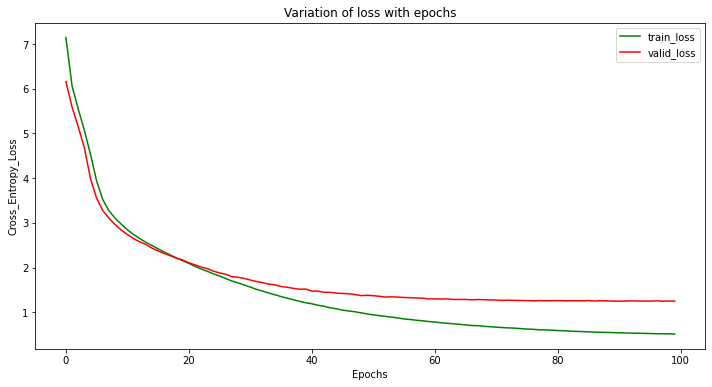

In [44]:
def plot_losses(train_losses, valid_losses):
  fig, ax = plt.subplots(figsize = (12, 6))
  epochs = list(range(len(train_losses)))
  ax.plot(epochs, train_losses, label = 'train_loss', color = 'green')
  ax.plot(epochs, valid_losses, label = 'valid_loss', color = 'red')
  ax.legend()
  ax.set(xlabel = 'Epochs', ylabel = 'Cross_Entropy_Loss', title = 'Variation of loss with epochs')

plot_losses(train_losses, valid_losses)

In [45]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [46]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 8, n_cols = 1):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(200,100))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [47]:
def show_results(infer_data, example_idx):
  src = vars(infer_data.examples[example_idx])['src']
  trg = vars(infer_data.examples[example_idx])['trg']
  # print(f'src = {" ".join(src)}')
  # print(f'trg :\n {" ".join(trg)}')

  translation, attention = translate_sentence(src, SRC, TRG, model, device)

  # print(f'predicted trg :\n {" ".join(translation)}')

  # display_attention(src, translation, attention)
  return " ".join(src), "".join(trg), "".join(translation)

In [48]:
from tqdm.notebook import tqdm

In [49]:
results_df = pd.DataFrame()
for i in tqdm(range(len(test_data)), total = len(test_data)):
  # print(i)
  src, target, translation = show_results(test_data, i)
  row_df = pd.DataFrame({'src': src, 'target': target, 'translation': translation}, index = [0])
  results_df = pd.concat([results_df, row_df])

In [50]:
results_df.reset_index(drop = True, inplace = True)

In [51]:
results_df

,src,target,translation
0,write a python function to get the surface_are...,"def rec_prism_surface_area(length, width, heig...","def cal_area_rect(length, height):\n return..."
1,write a python function to add elements of two...,"def add_two_lists(list1, list2):\n list1 = [...","def add_two_lists(list1, list2):\n list2 = [..."
2,write a lambda function to multiply two numbers,"multiply = lambda a, b: a*b\n","a = {1, 2, 4, 6, 7}\nresult = lambda a: a + b,..."
3,write a python function to generate cube numbe...,def cube_numbers(n):\n for i in range(n):\n...,"def square_numbers(n):\n for i in range(1, ..."
4,define a custom exception class which takes a ...,class MyError(Exception):\n def __init__(se...,"class Person:\n def __init__(self, msg):\n ..."
...,...,...,...
172,write a python function that returns the h...,"def calculate_hcf(x1, x2):\n if x1 == 0:\n ...","def hcf(num1, num2):\n if num1 >= num2:\n ..."
173,write a program to compute /+/+/+ ... +n / n+ ...,"n=int(raw_input())\nsum=0.0\nfor i in range(1,...","num = int(input(""Enter a number: ""))\nsum = 0\..."
174,write a python program which takes input a num...,"N = int(input(""Please enter a number ""))\nfirs...","n = int(input(""Enter Number: ""))\nn = 0\nwhile..."
175,write a python class that will initiate a numb...,"class Number:\n\tdef __init__(self, num):\n\t\...","class __init__(self, self):\n def __init__(..."


In [247]:
def print_output(example_idx, data, figsize = (20, 40), cmap = 'Bone'):
  
  example_idx = example_idx
  src = vars(data.examples[example_idx])['src']
  trg = vars(data.examples[example_idx])['trg']
  translation, attention = translate_sentence(src, SRC, TRG, model, device)

  # w_pixel_ratio = 0.8
  # h_pixel_ratio = 4
  # w = int((len(src)+2)/w_pixel_ratio) * 2
  # h = int(len(translation)/h_pixel_ratio) * 4
  fig, ax = plt.subplots(4, 2 , figsize = figsize)
  axises = ax.flatten()

  for i in range(len(axises)):
    attention_head = i
    _attention = attention.squeeze(0)[attention_head].cpu().detach().numpy()
    sns.heatmap(_attention, cmap = cmap, ax = axises[i], cbar=False)
    axises[i].set_xticklabels(['<sos>']+[t.lower() for t in src]+['<eos>'], rotation=90)
    axises[i].set_yticklabels(translation, rotation = 0)
    axises[i].tick_params(labelsize=12)
    axises[i].set(title = f"Attention Head {i+1}")
  if "<eos>" in translation:
    translation.remove("<eos>")
  print(f"Prompt : {' '.join(src)}")
  print("\n")
  print(f"Target Source Code :\n{''.join(trg)}")
  print("\n")
  print(f"Predicted Source Code :\n{''.join(translation)}")

# 25 Examples from the test set

Prompt : create and print a dictionary


Target Source Code :
thisdict = {
  "brand": "Ford",
  "model": "Mustang",
  "year": 1964
}
print(f"Sample Dictionary:{thisdict}")



Predicted Source Code :
thisdict = {
  "brand": "Ford",
  "model": "Mustang",
  "year": 1964
}
print(f"Sample Dictionary:{thisdict}")



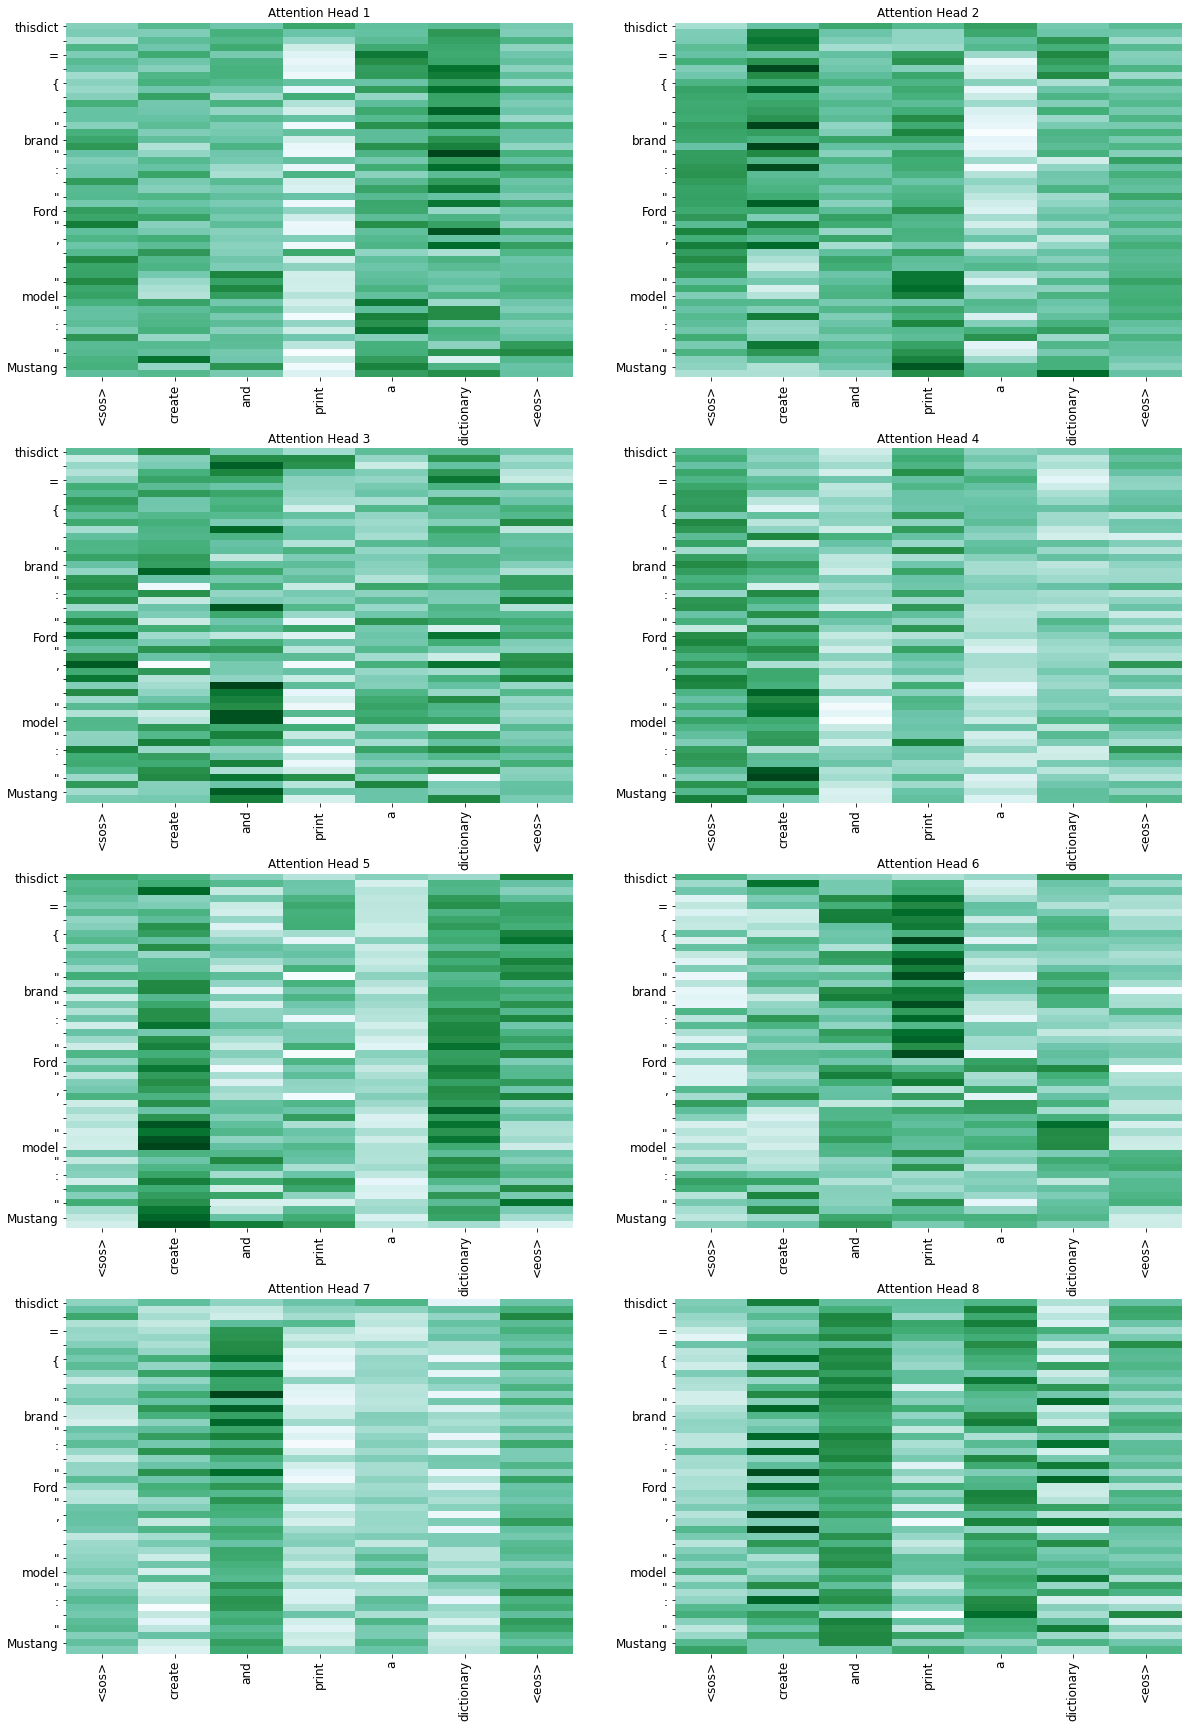

In [248]:
# Example 1
print_output(34, test_data, (20, 30), 'BuGn')

Prompt : write a program to calculate exponents of an input


Target Source Code :
input = 9
exponent = 2
final = pow(input, exponent)
print(f'Exponent Value is:{final}')



Predicted Source Code :
input = 9
exponent = 2
final = pow(input, exponent)
print(f'Exponent Value is:{final}')



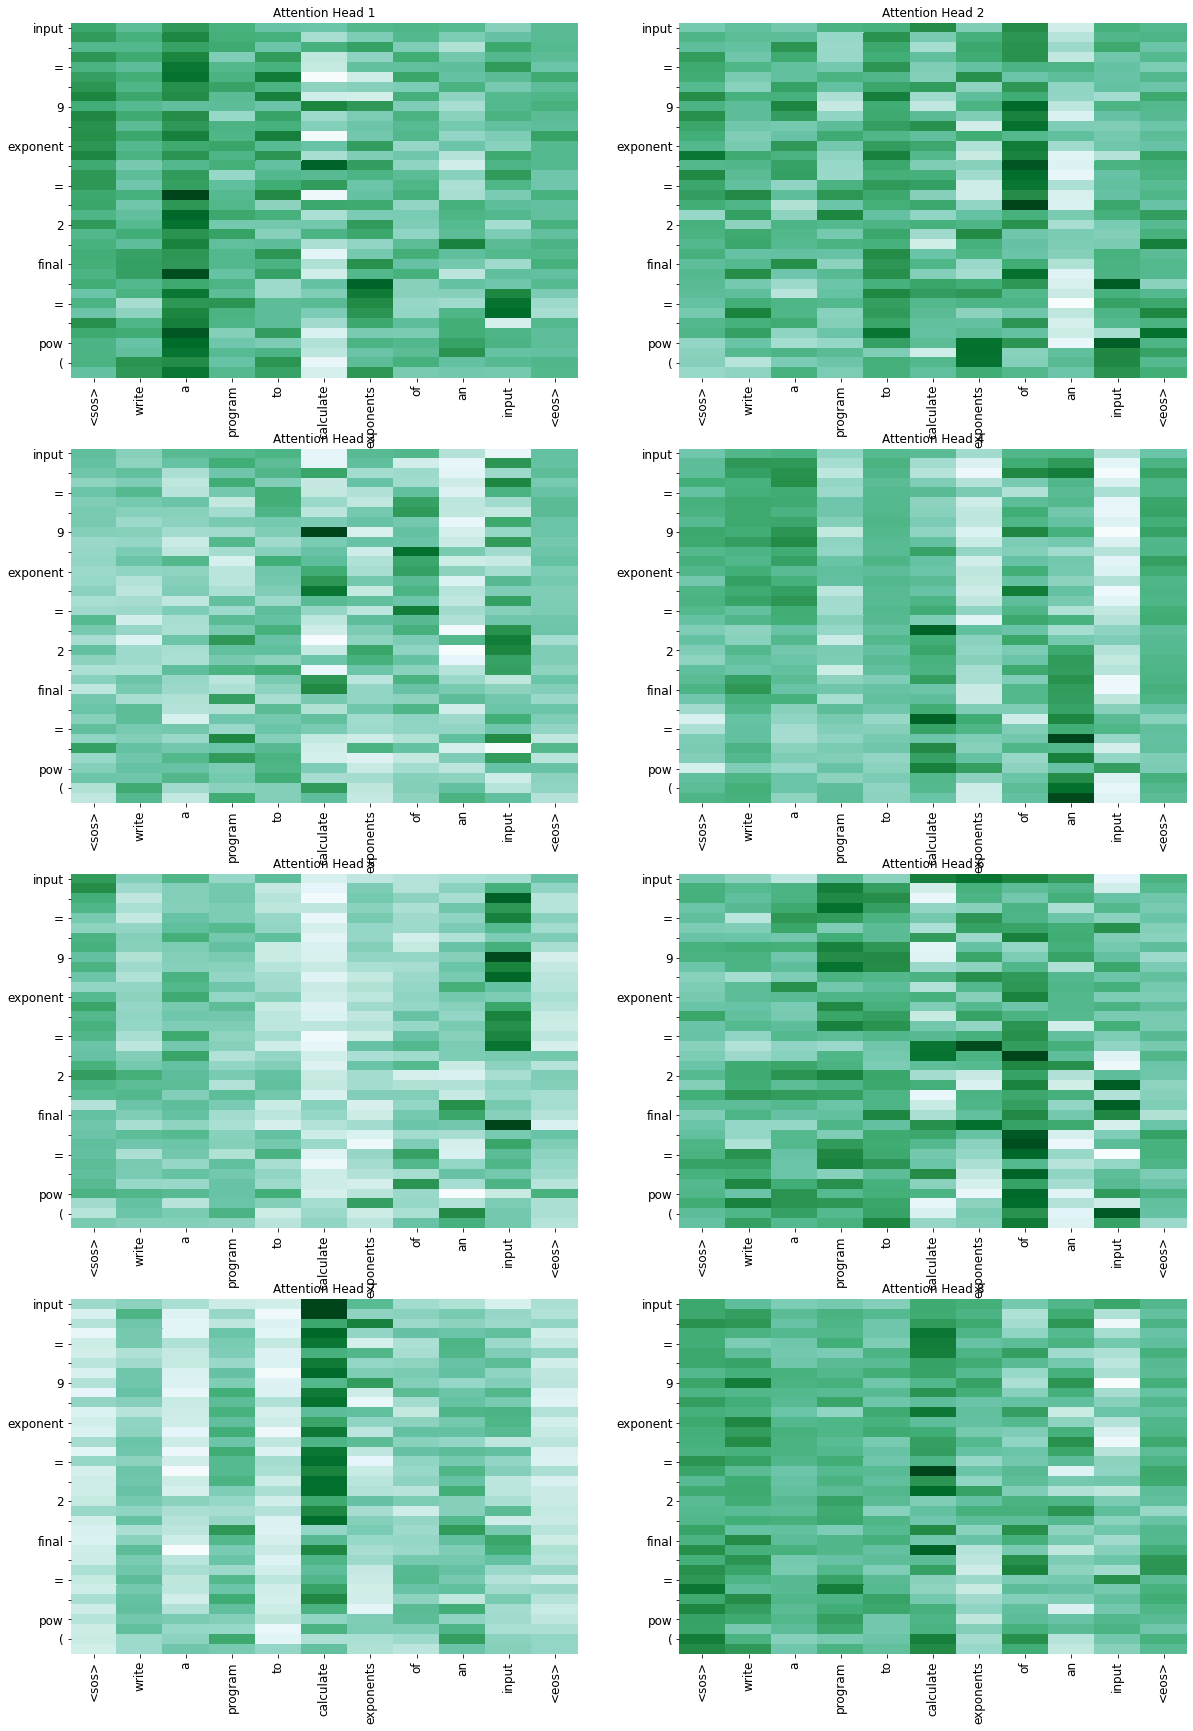

In [254]:
# Example 3
print_output(7, test_data, (20, 30), 'BuGn')

Prompt : test if string contains upper case


Target Source Code :
word = "Hello World"
check = word.isupper()
print(f"String contains upper case?:{check}")



Predicted Source Code :
word = "Hello World"
check = word.isupper()
print(f"String contains digits?:{check}")



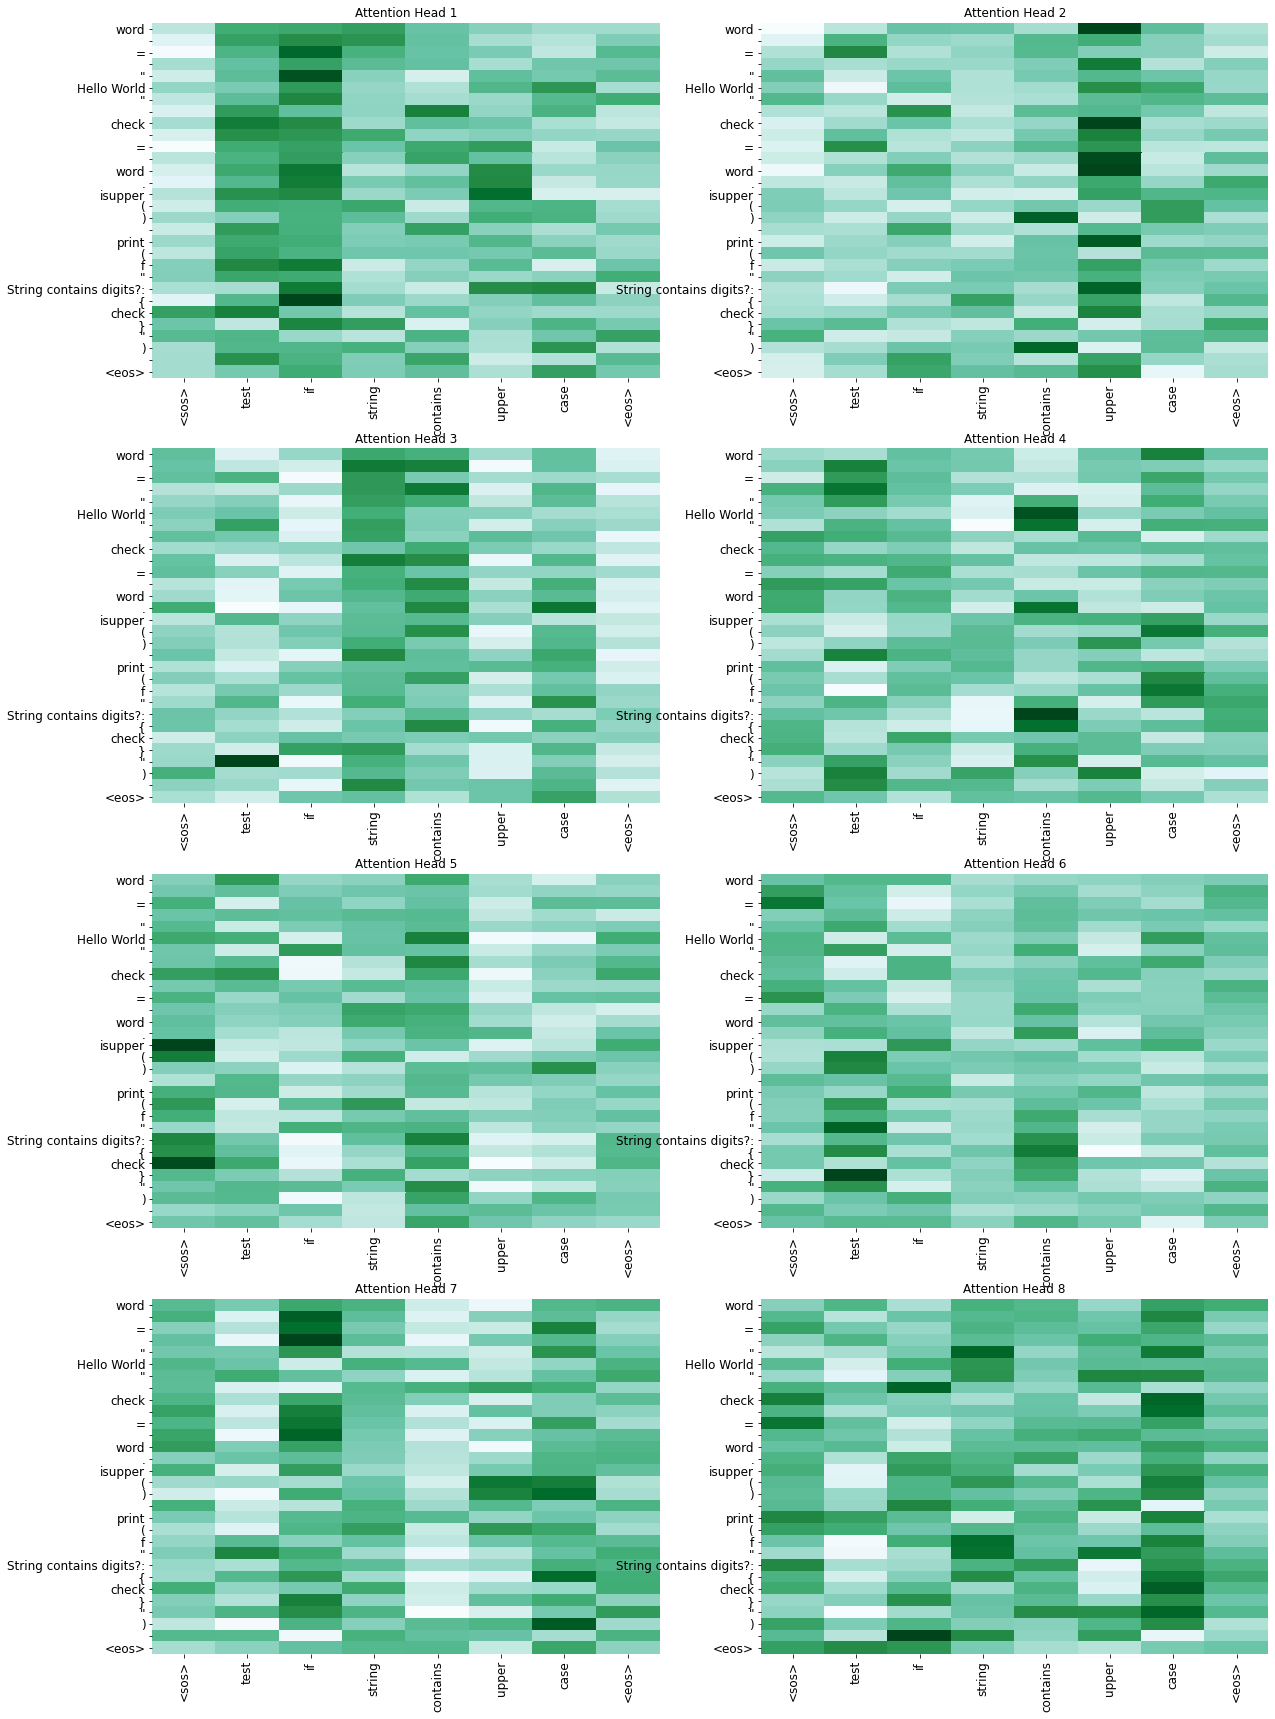

In [255]:
# Example 4
print_output(6, test_data, (20, 30), 'BuGn')

Prompt : prints ten dots


Target Source Code :
ten = "." * 10
print(f"Ten dots: {ten}")



Predicted Source Code :
ten = "." * 10
print(f"Ten dots: {ten}")



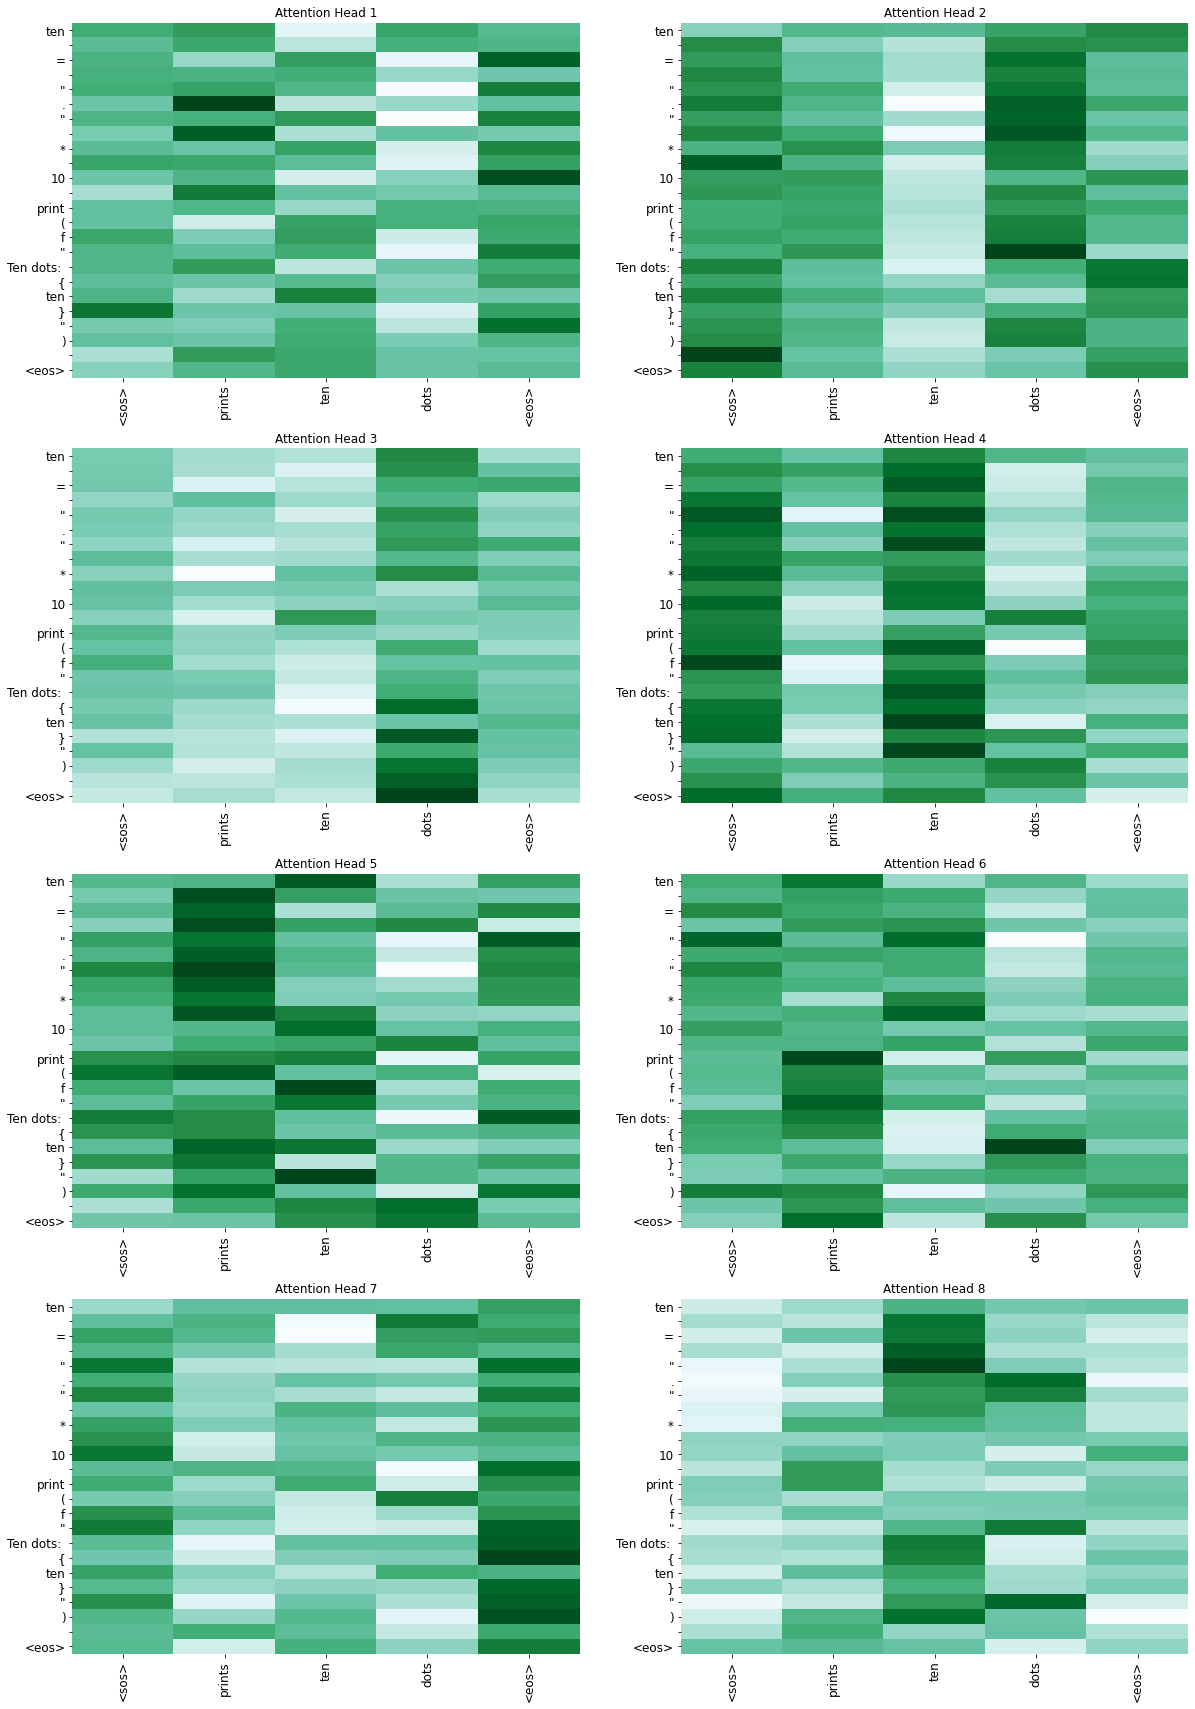

In [256]:
# Example 5
print_output(11, test_data, (20, 30), 'BuGn')

Prompt : please write a program to print python built - in functions document of abs ( )


Target Source Code :
print(abs.__doc__)



Predicted Source Code :
print(__doc__)



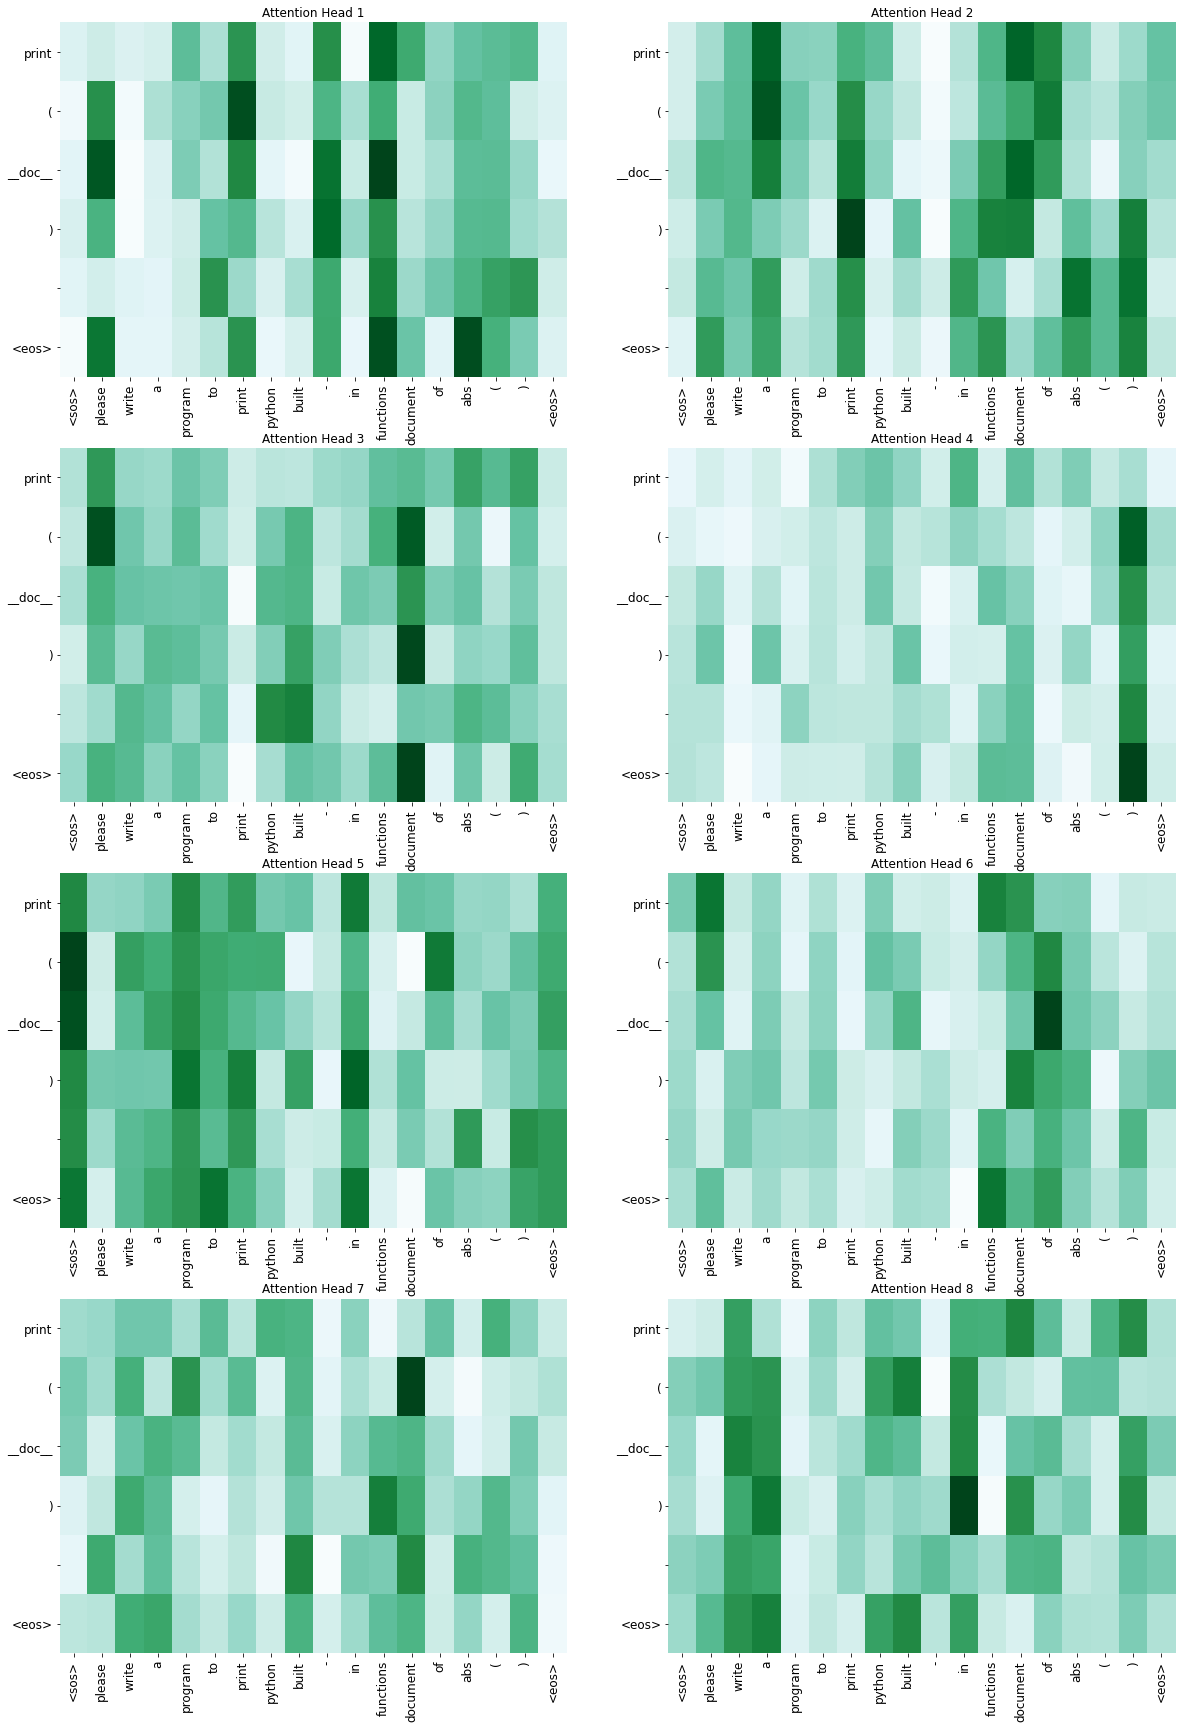

In [257]:
# Example 6
print_output(19, test_data, (20, 30), 'BuGn')

Prompt : write a python function for bitwise division with given number of shifts


Target Source Code :
def bit_div(n, shift):
    return n >> shift



Predicted Source Code :
def bit_mul(n, shift):
    return n << shift



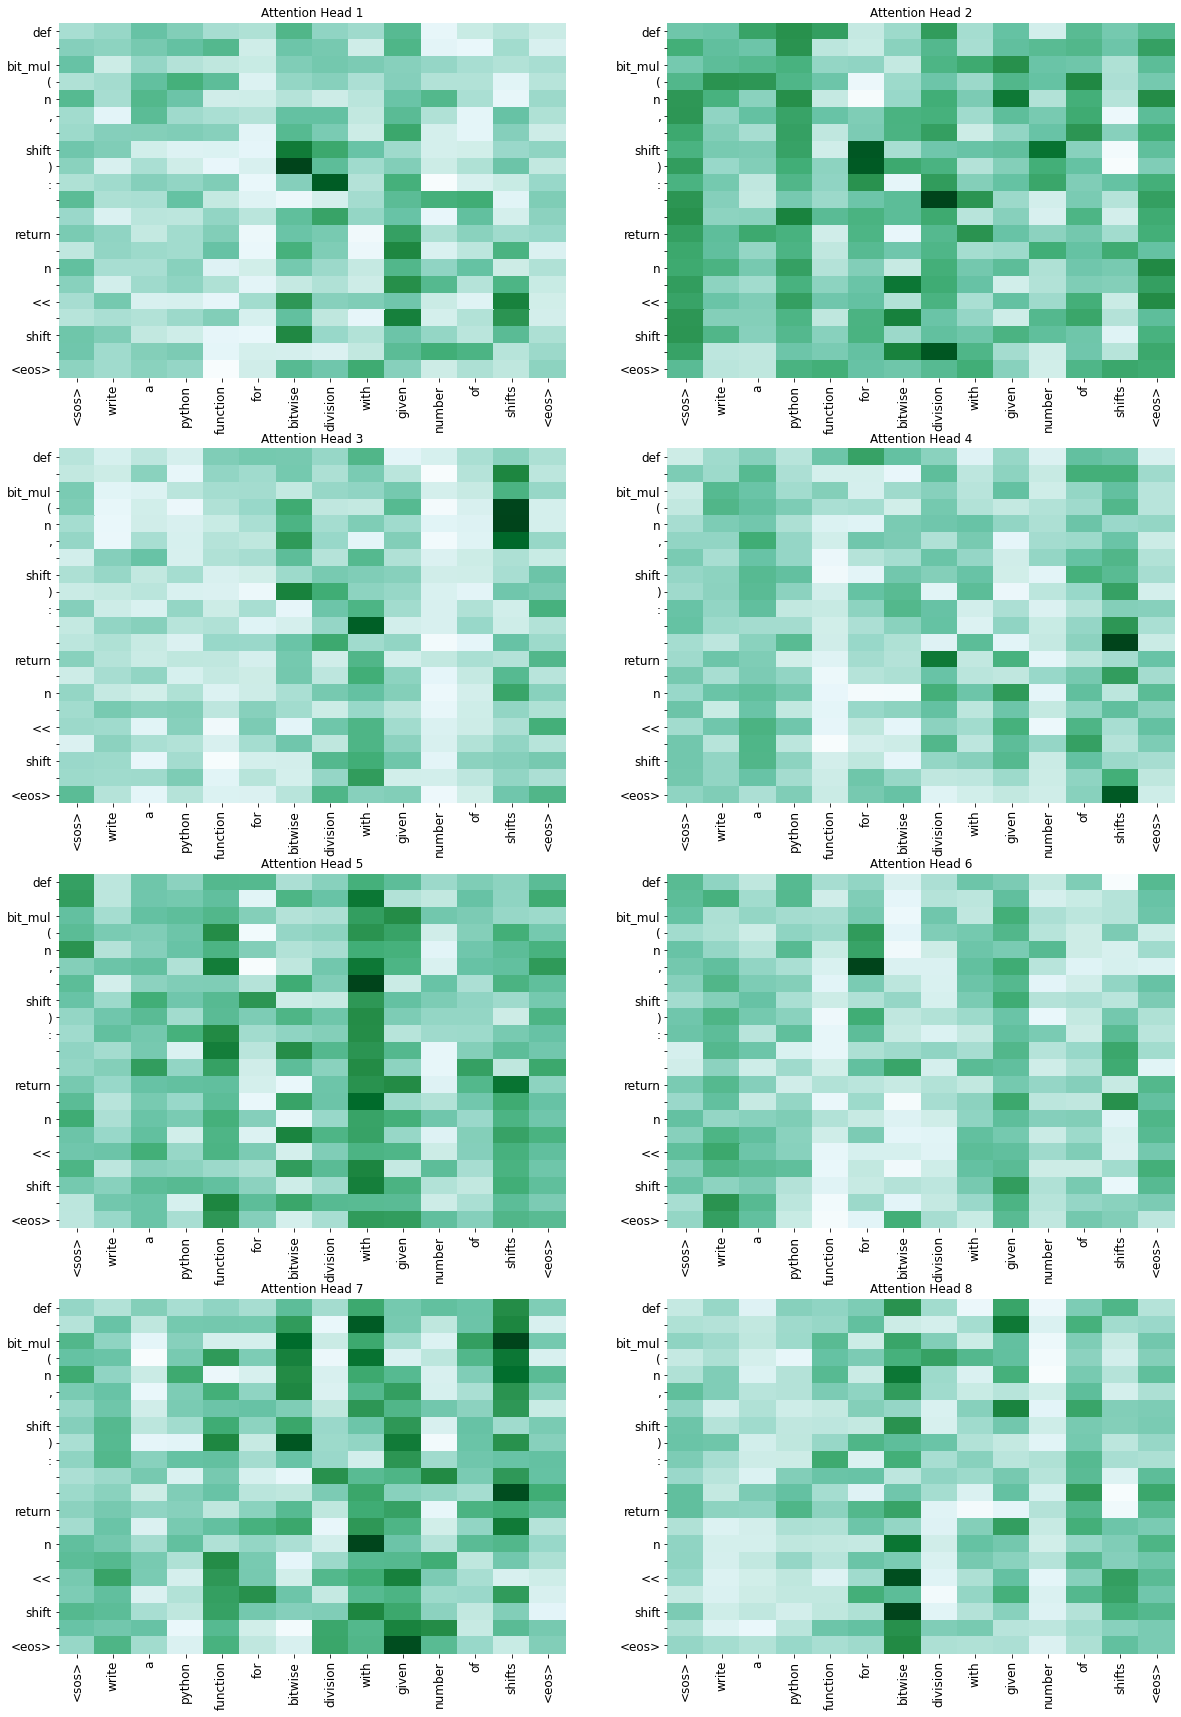

In [258]:
# Example 7
print_output(21, test_data, (20, 30), 'BuGn')

Prompt : write a function to calculate the total resistance of resistances in series in a given list


Target Source Code :
def cal_total_res_in_series(res_list:list)->float:
    return sum(res_list)



Predicted Source Code :
def cal_total_res_in_parallel(res_list:list)->float:
    return sum([1/r for r in res_list])



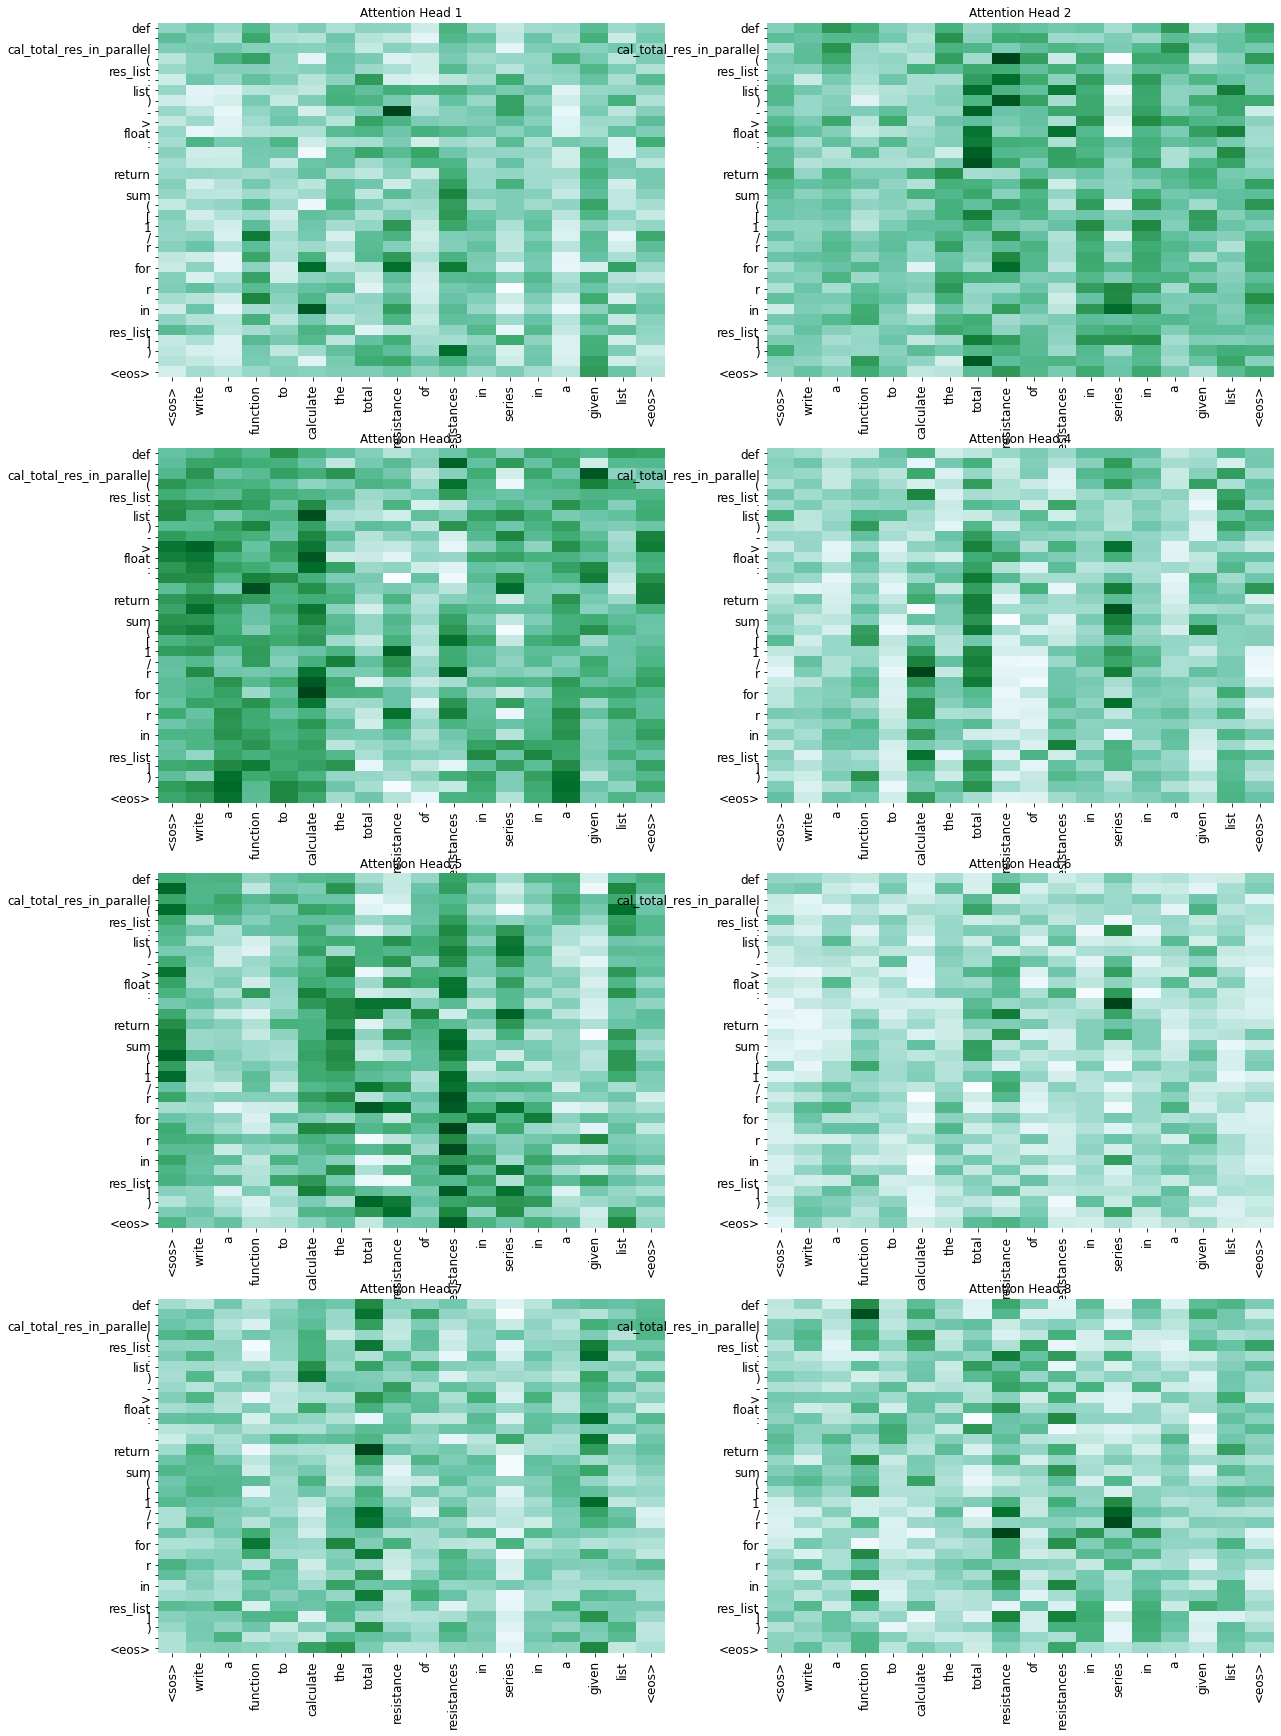

In [259]:
# Example 8
print_output(26, test_data, (20, 30), 'BuGn')

Prompt : write a python function that returns the input list sorted in ascending order


Target Source Code :
def sort_ascending(list_to_be_sorted):
    return sorted(list_to_be_sorted)



Predicted Source Code :
def reverse(list_to_be_sorted):
    return sorted(list_to_be_sorted)



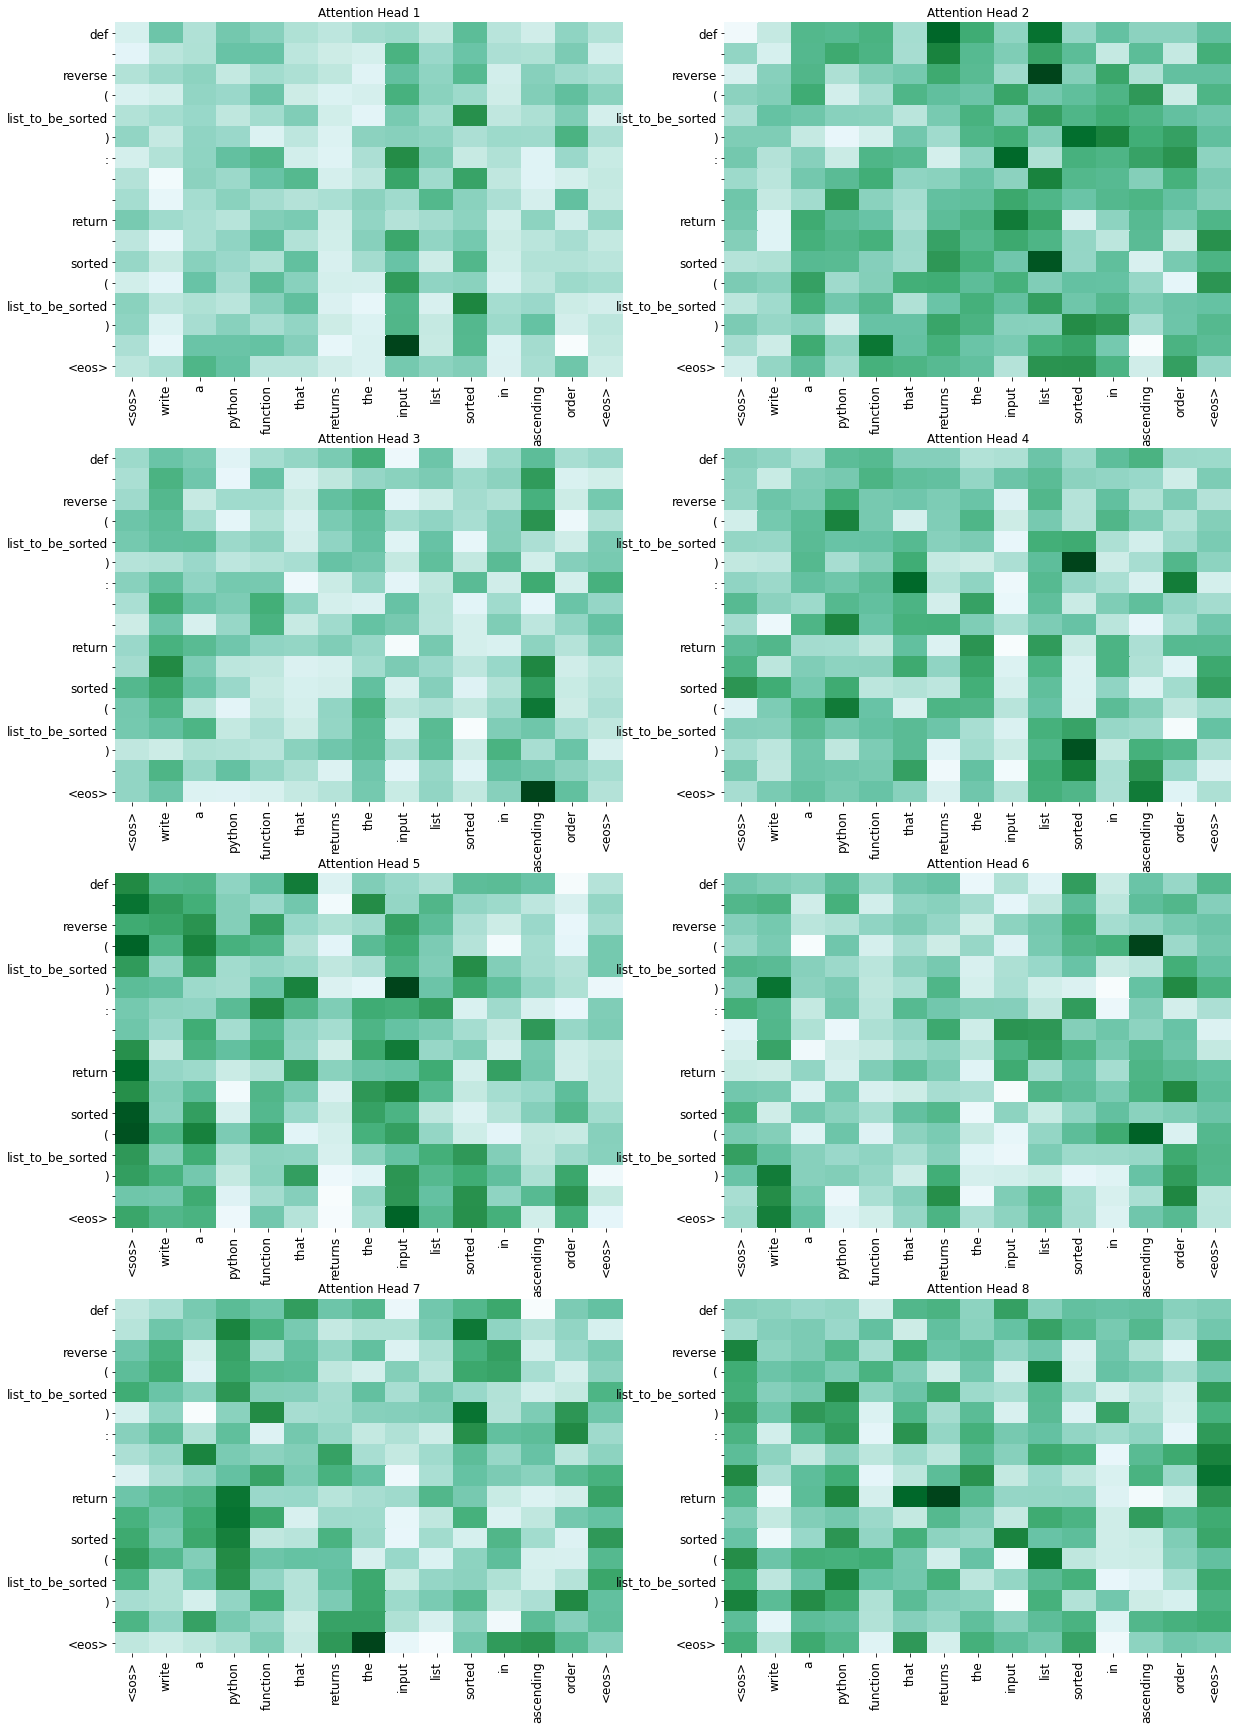

In [260]:
# Example 9
print_output(32, test_data, (20, 30), 'BuGn')

Prompt : write a function to calculate the volume v of ideal gas based on ideal gas equation pressure p and tempreature t given


Target Source Code :
def find_volume_of_ideal_gas(pressure:float, temp:float,n:float)->float:
    r = 8.3145 
    return (n*r*temp)/pressure



Predicted Source Code :
def find_volume_of_ideal_gas(pressure:float, temp:float,n:float)->float:
    r = 8.3145 
    return (n*r*temp)/pressure



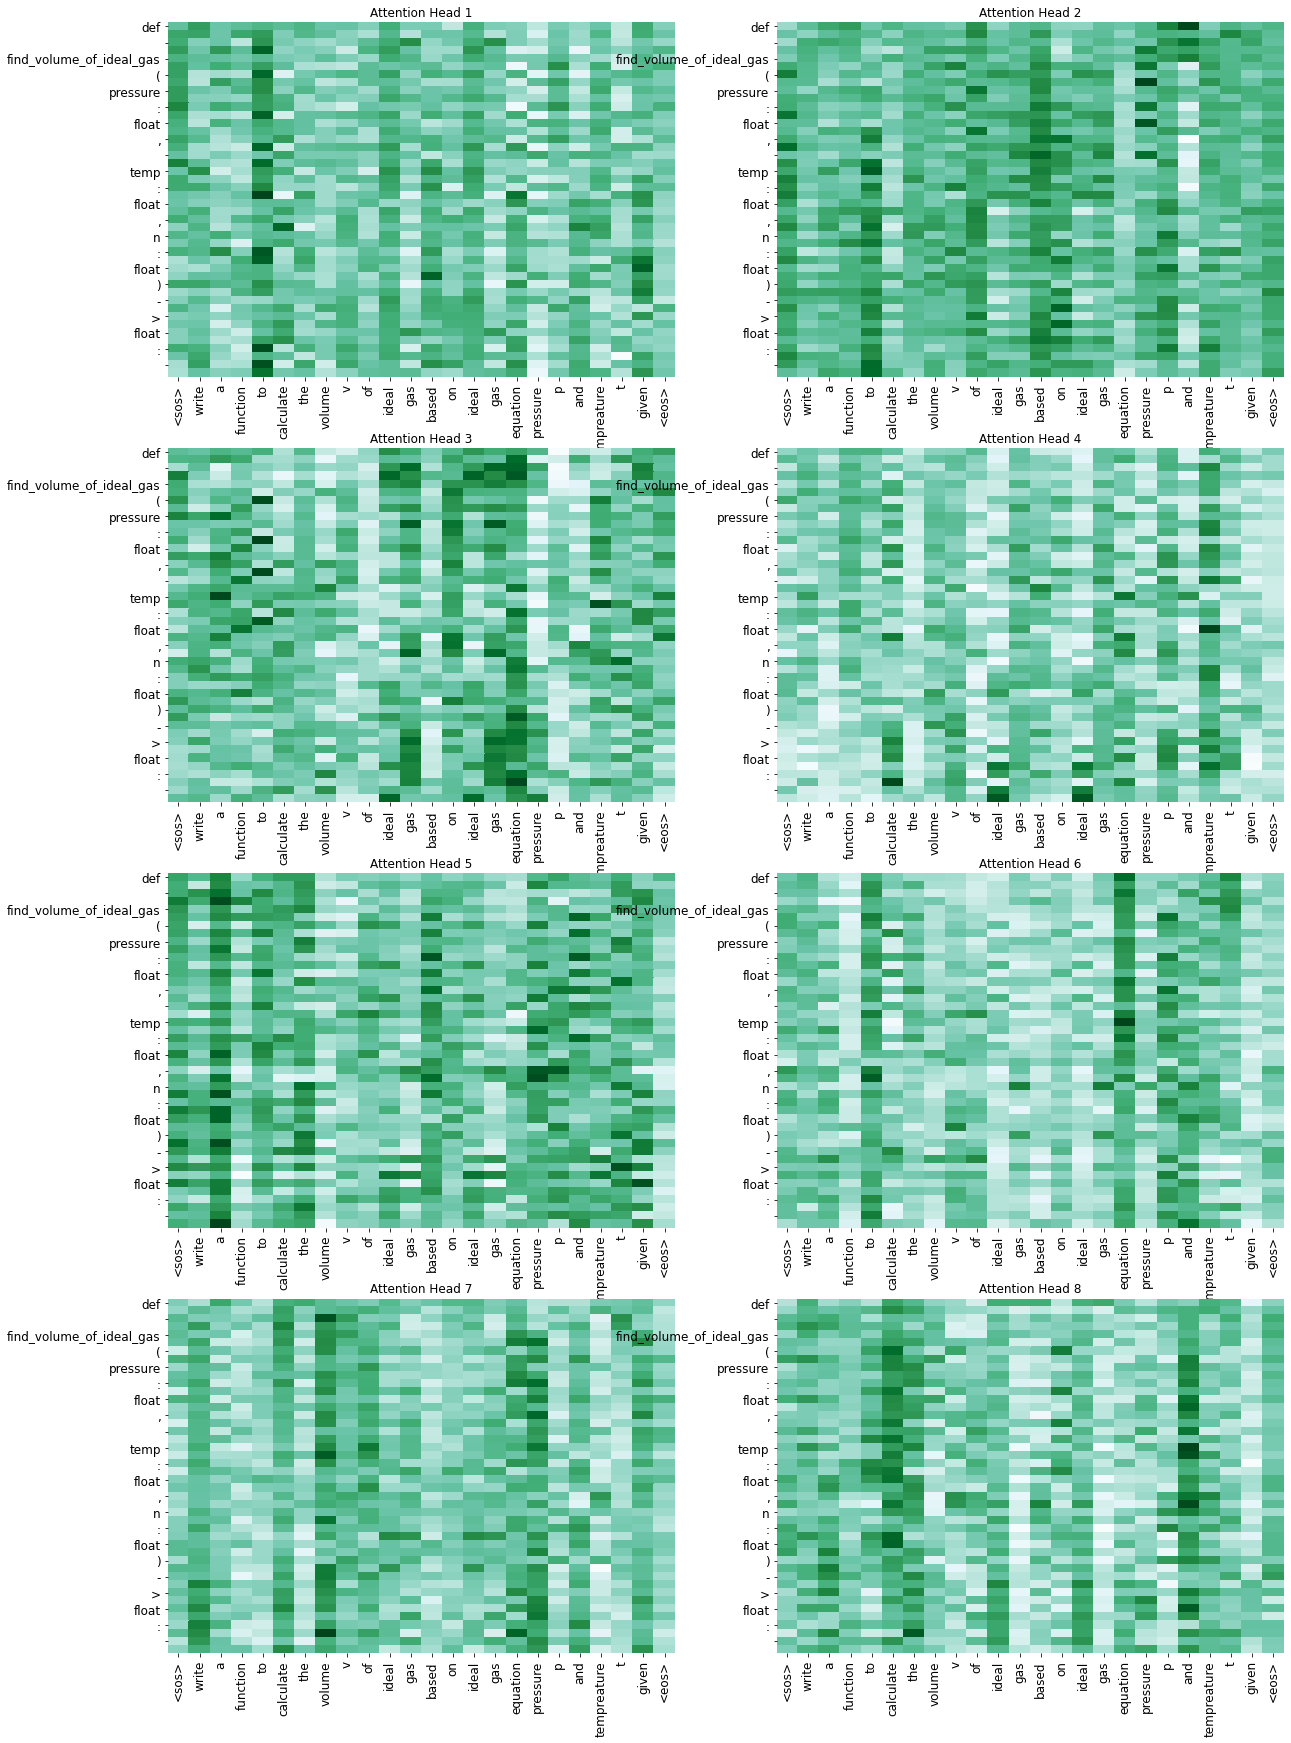

In [261]:
# Example 10
print_output(33, test_data, (20, 30), 'BuGn')

Prompt : print a unicode string " hello world " .


Target Source Code :
unicodeString = u"hello world!"
print unicodeString



Predicted Source Code :
unicodeString = input("hello world!")
print(unicodeString)



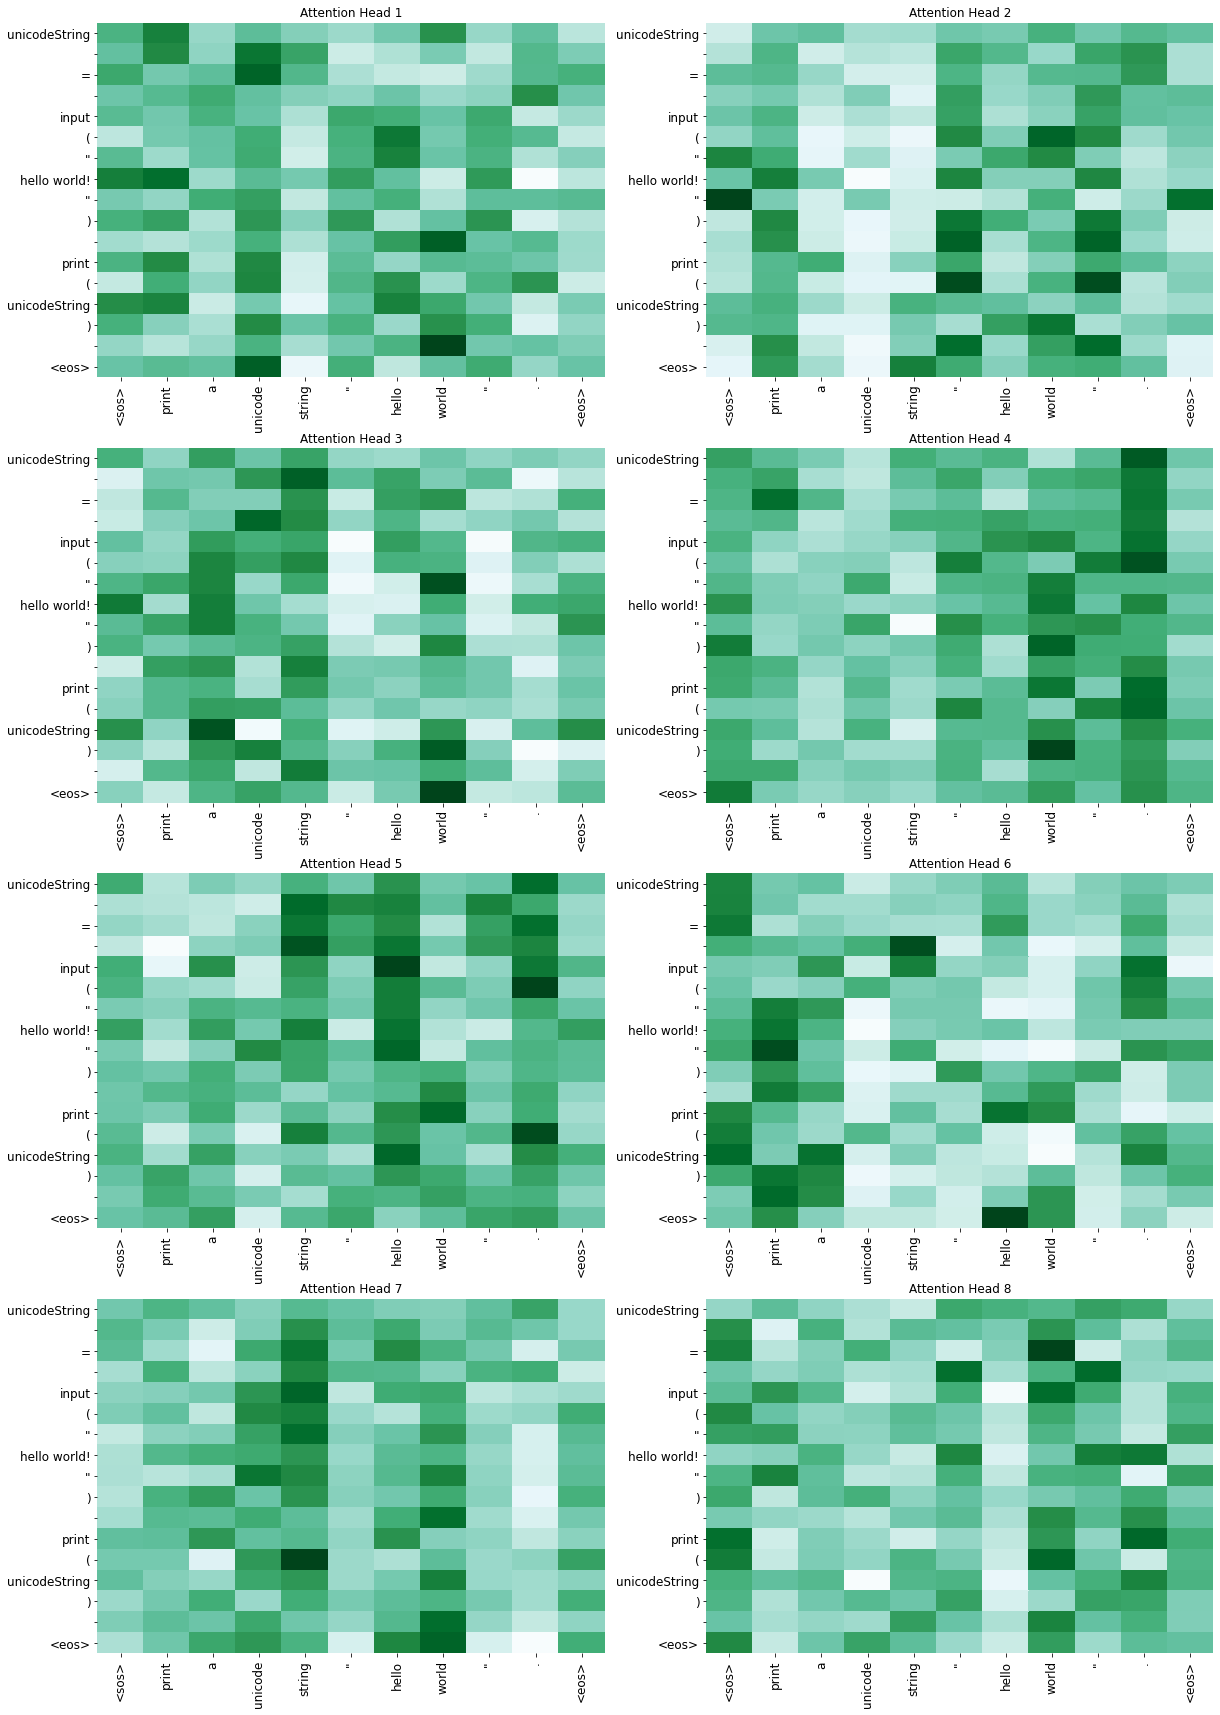

In [262]:
# Example 11
print_output(43, test_data, (20, 30), 'BuGn')

Prompt : custom counter function


Target Source Code :
def custom_counter():
    """
    An implementation of closures
    """
    x = 0
    def inner():
       nonlocal x
       x += 1
       print(f' Switch or button is called {x} times')
     return inner



Predicted Source Code :
def inner(x):
    count = 0
    while x > 0:
        nonlocal x
        count += 1
        return inner



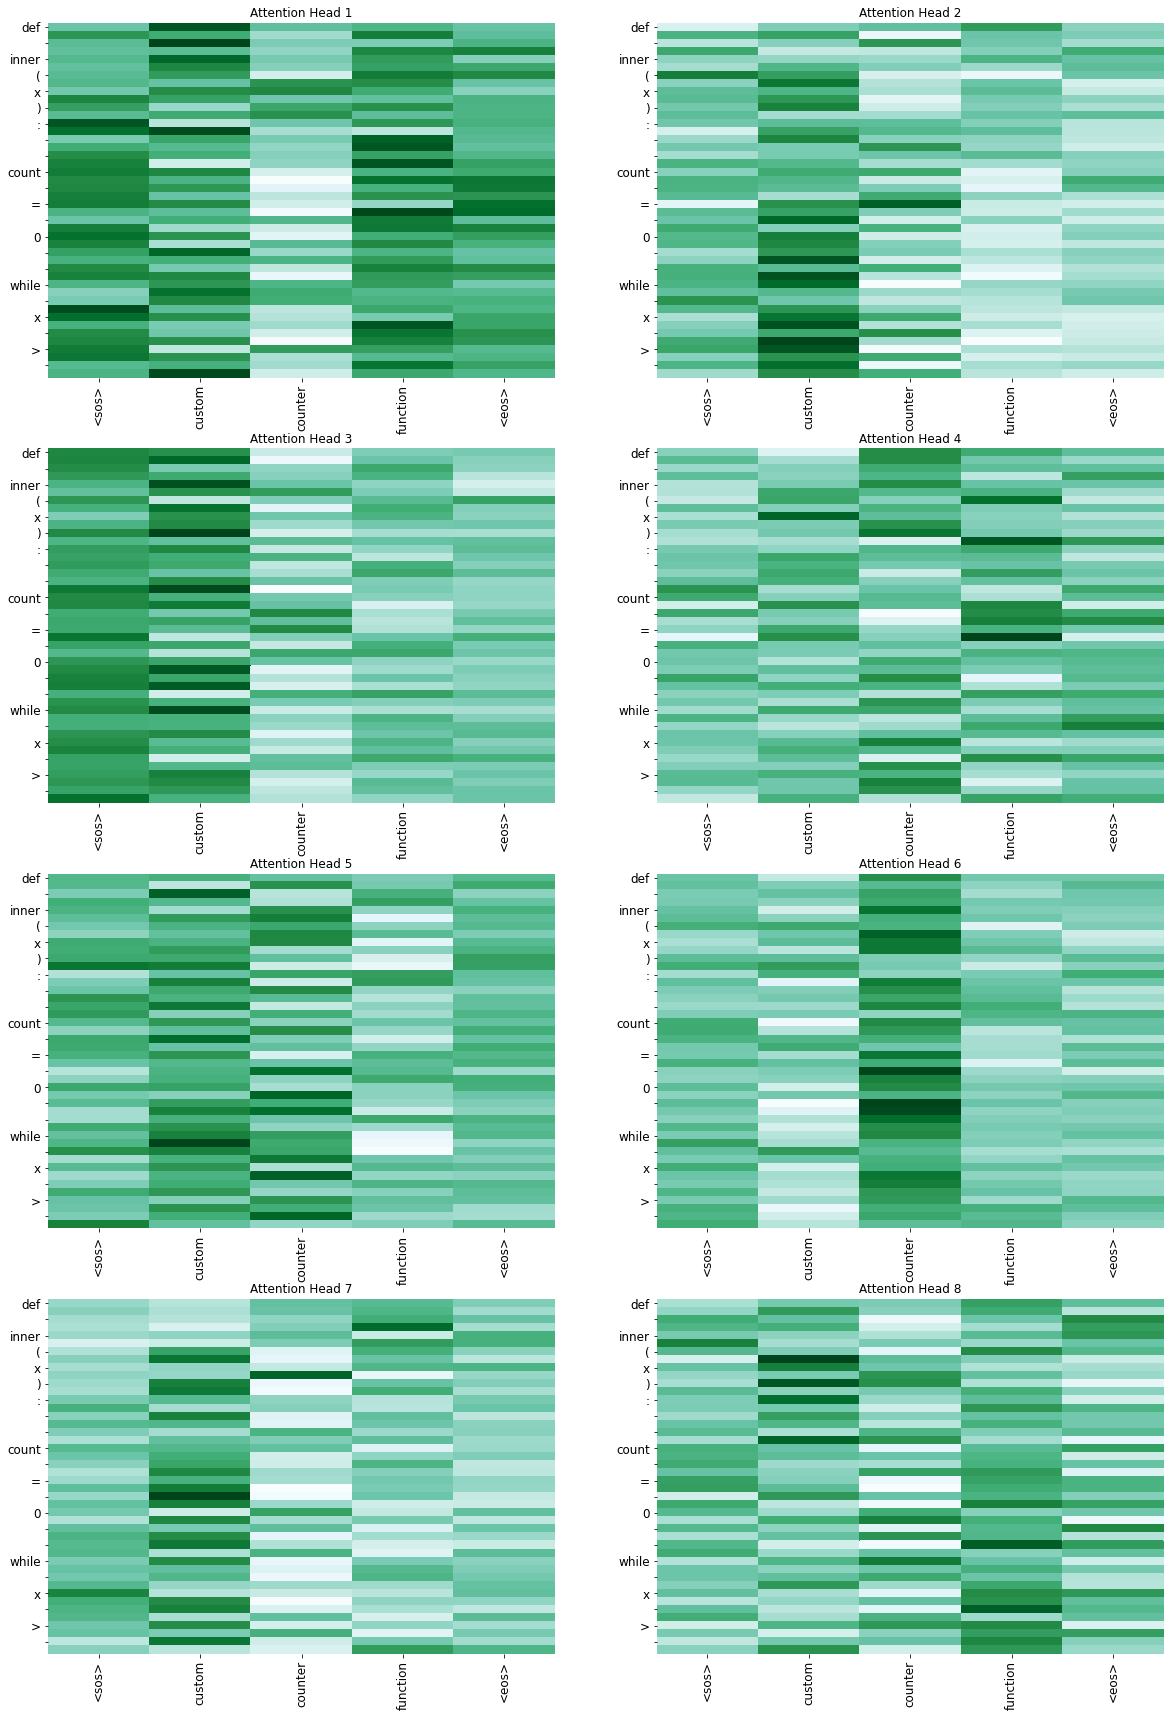

In [263]:
# Example 12
print_output(44, test_data, (20, 30), 'BuGn')

Prompt :   write a python function to get the surface_area of a cone with radius & slant height as input


Target Source Code :
def cone_surface_area(radius, slant_height):
    surface_area =  3.14 * (radius ** 2) + 3.14 * radius * slant_height
    return surface_area



Predicted Source Code :
def cal_cone_curved_surf_area(radius):
    surface_area = 3.14
    return pi*radius*height



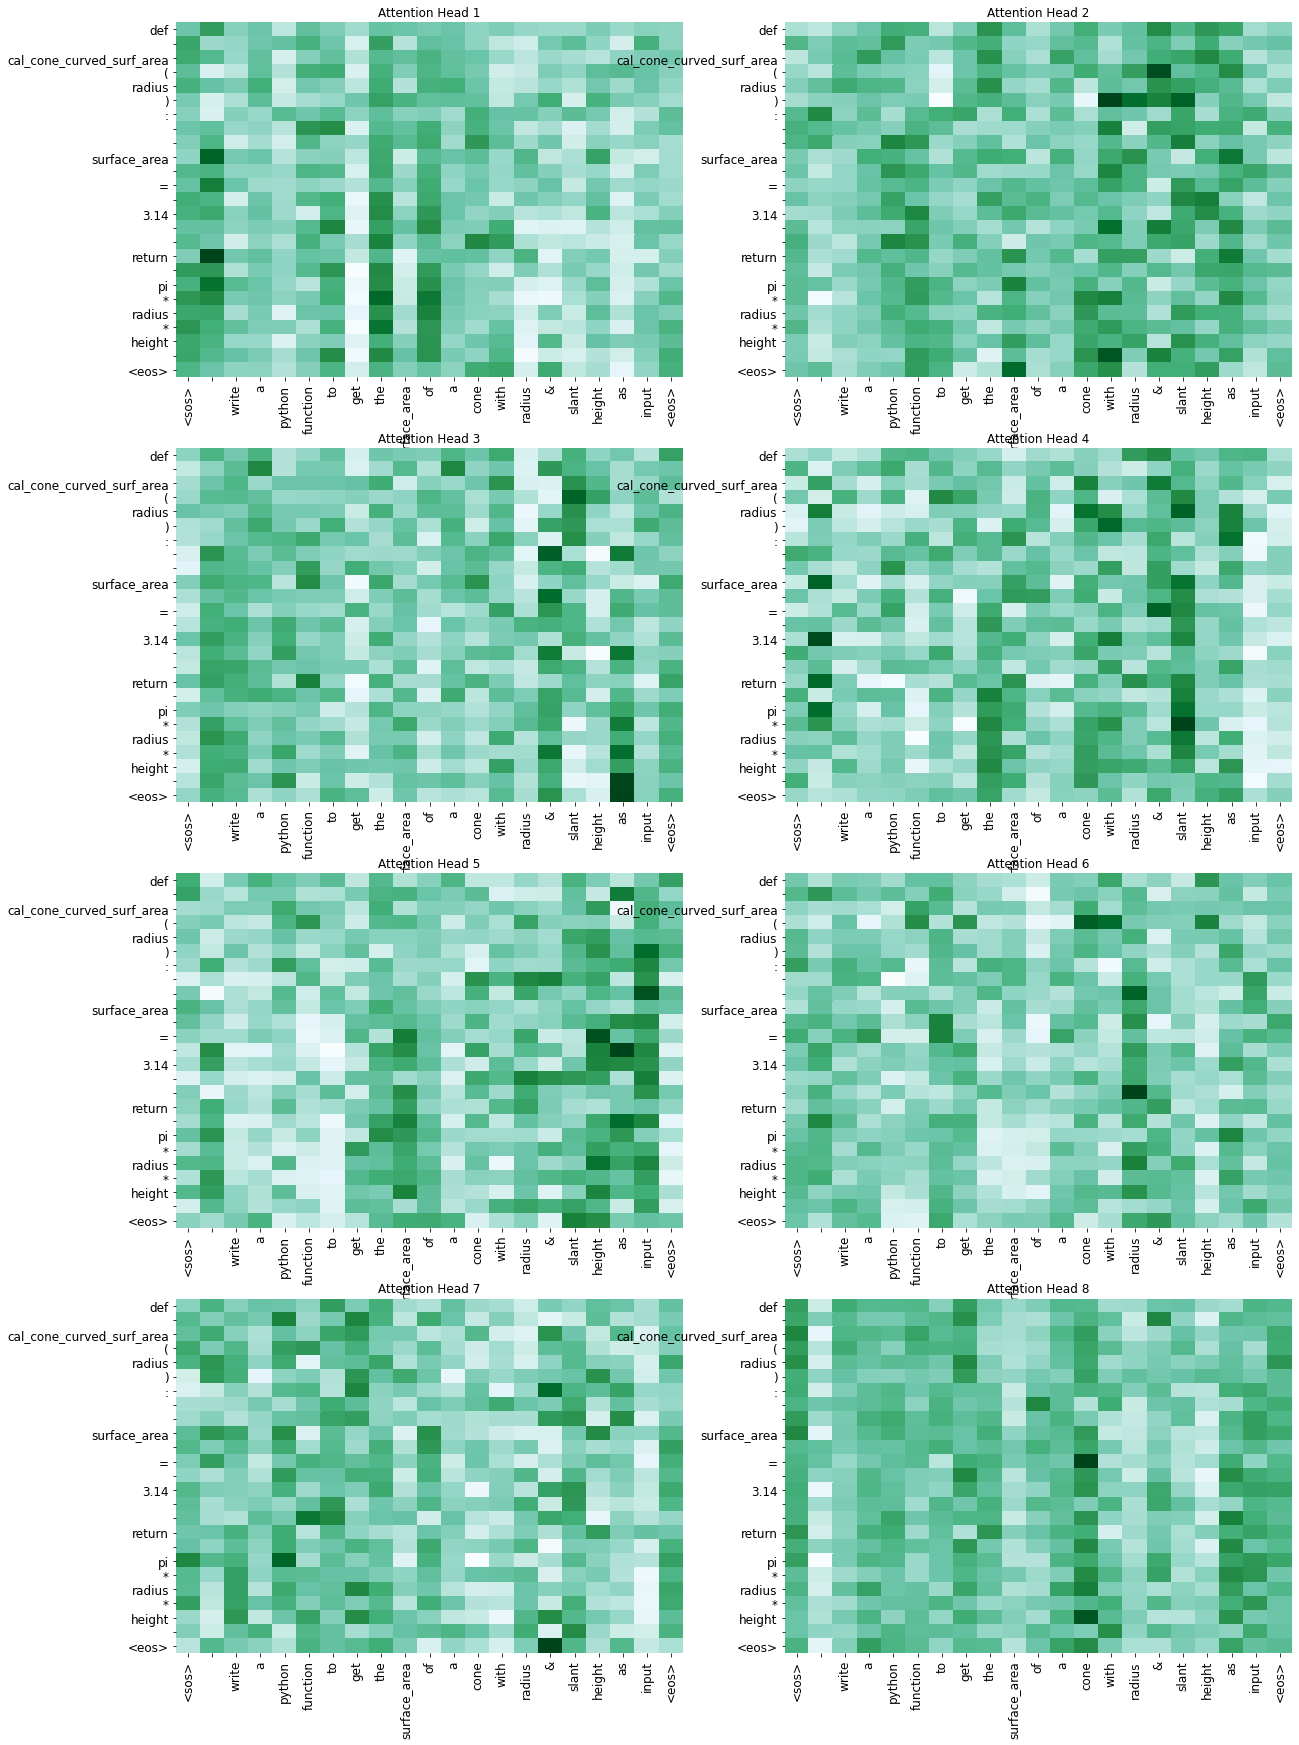

In [264]:
# Example 13
print_output(53, test_data, (20, 30), 'BuGn')

Prompt : write a function to return the angualr veolcity based on augualr distance travelled in radian unit and time taken


Target Source Code :
def cal_angular_velocity(angular_dist:float,time:float)->float:
    return angular_dist/time



Predicted Source Code :
def cal_angular_velocity(angular_dist:float,time:float)->float:
    return angular_dist/time



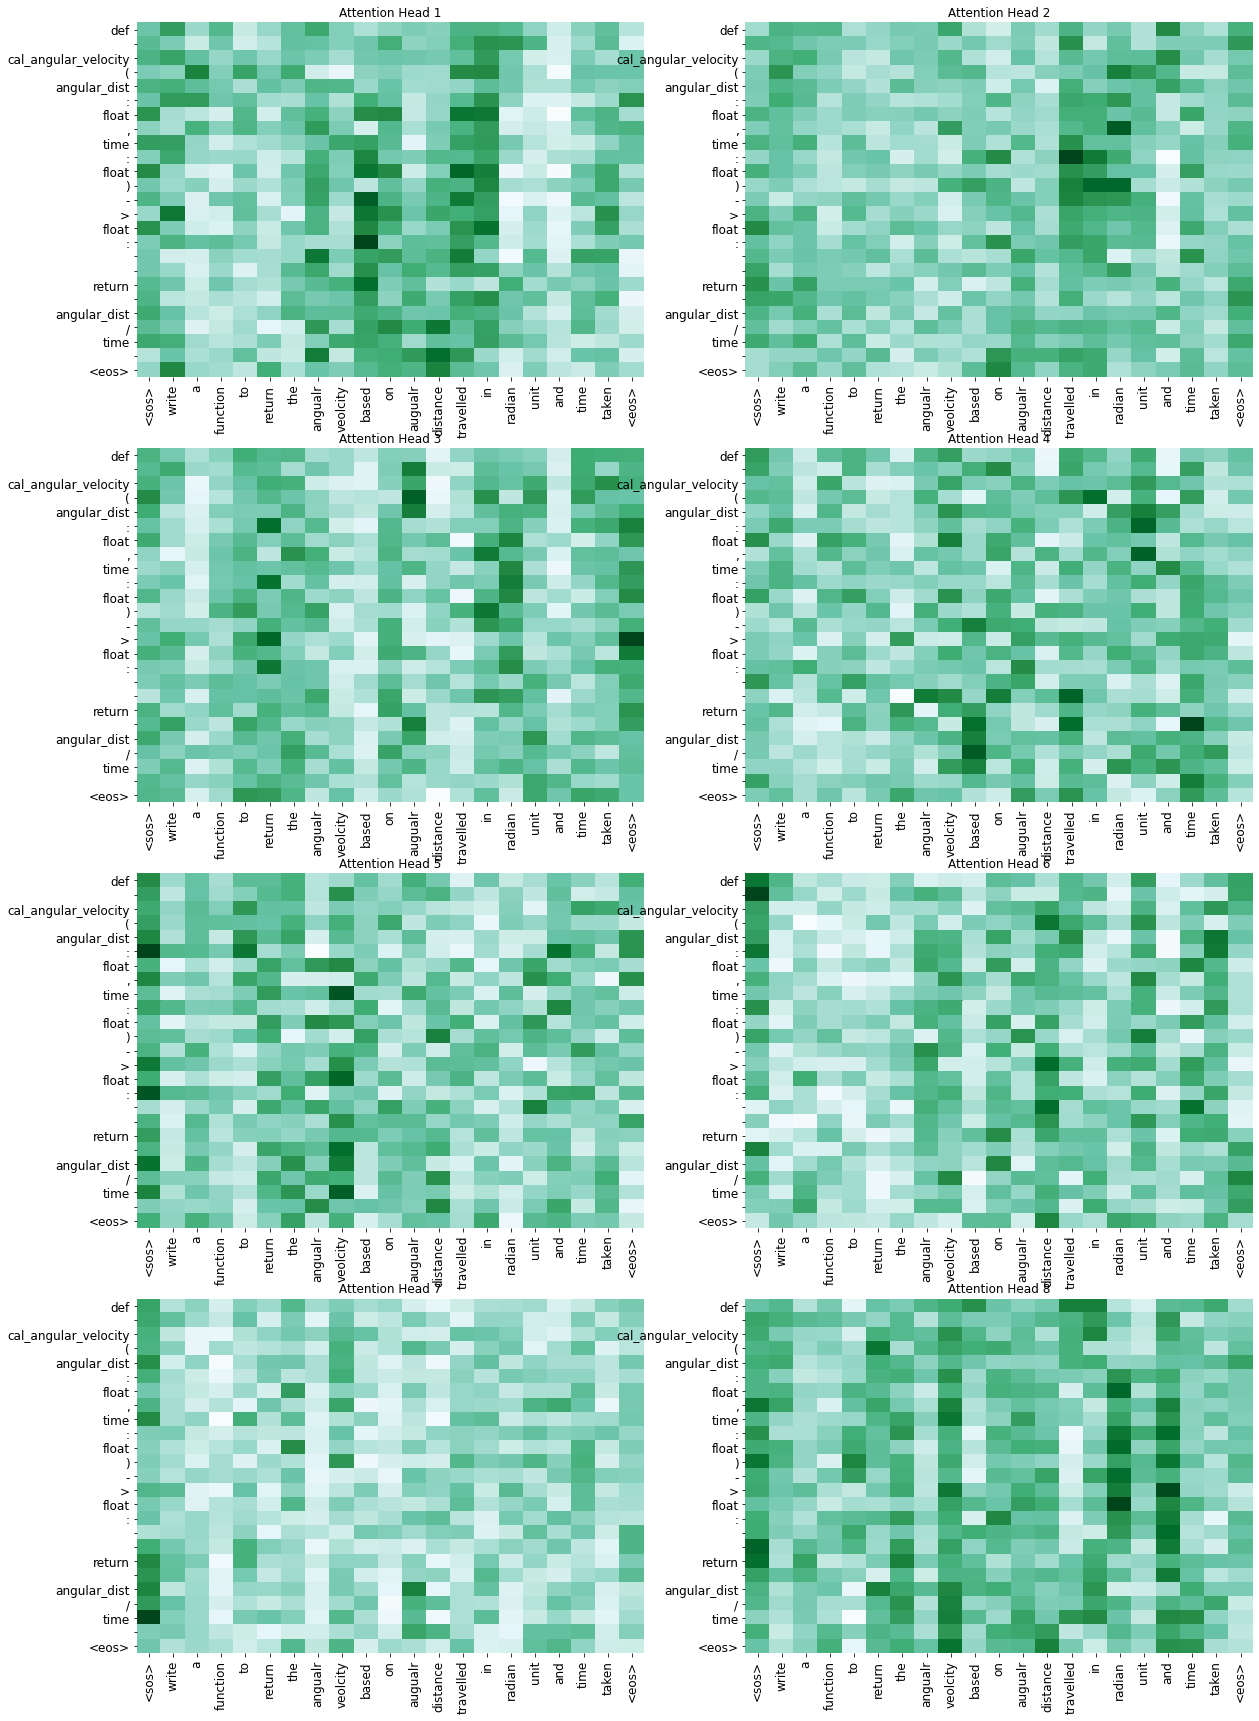

In [265]:
# Example 14
print_output(56, test_data, (20, 30), 'BuGn')

Prompt : # write a function to compress a given string . suppose a character ' c ' occurs consecutively x times in the string . replace these consecutive occurrences of the character ' c ' with   ( x , c ) in the string .


Target Source Code :
def compress(text):
    from itertools import groupby
    for k, g in groupby(text):
        print("({}, {})".format(len(list(g)), k), end=" ")



Predicted Source Code :
def compress(text):
    from itertools import groupby
    for item in groupby(text):
        print("\n{}.format(g, end="))



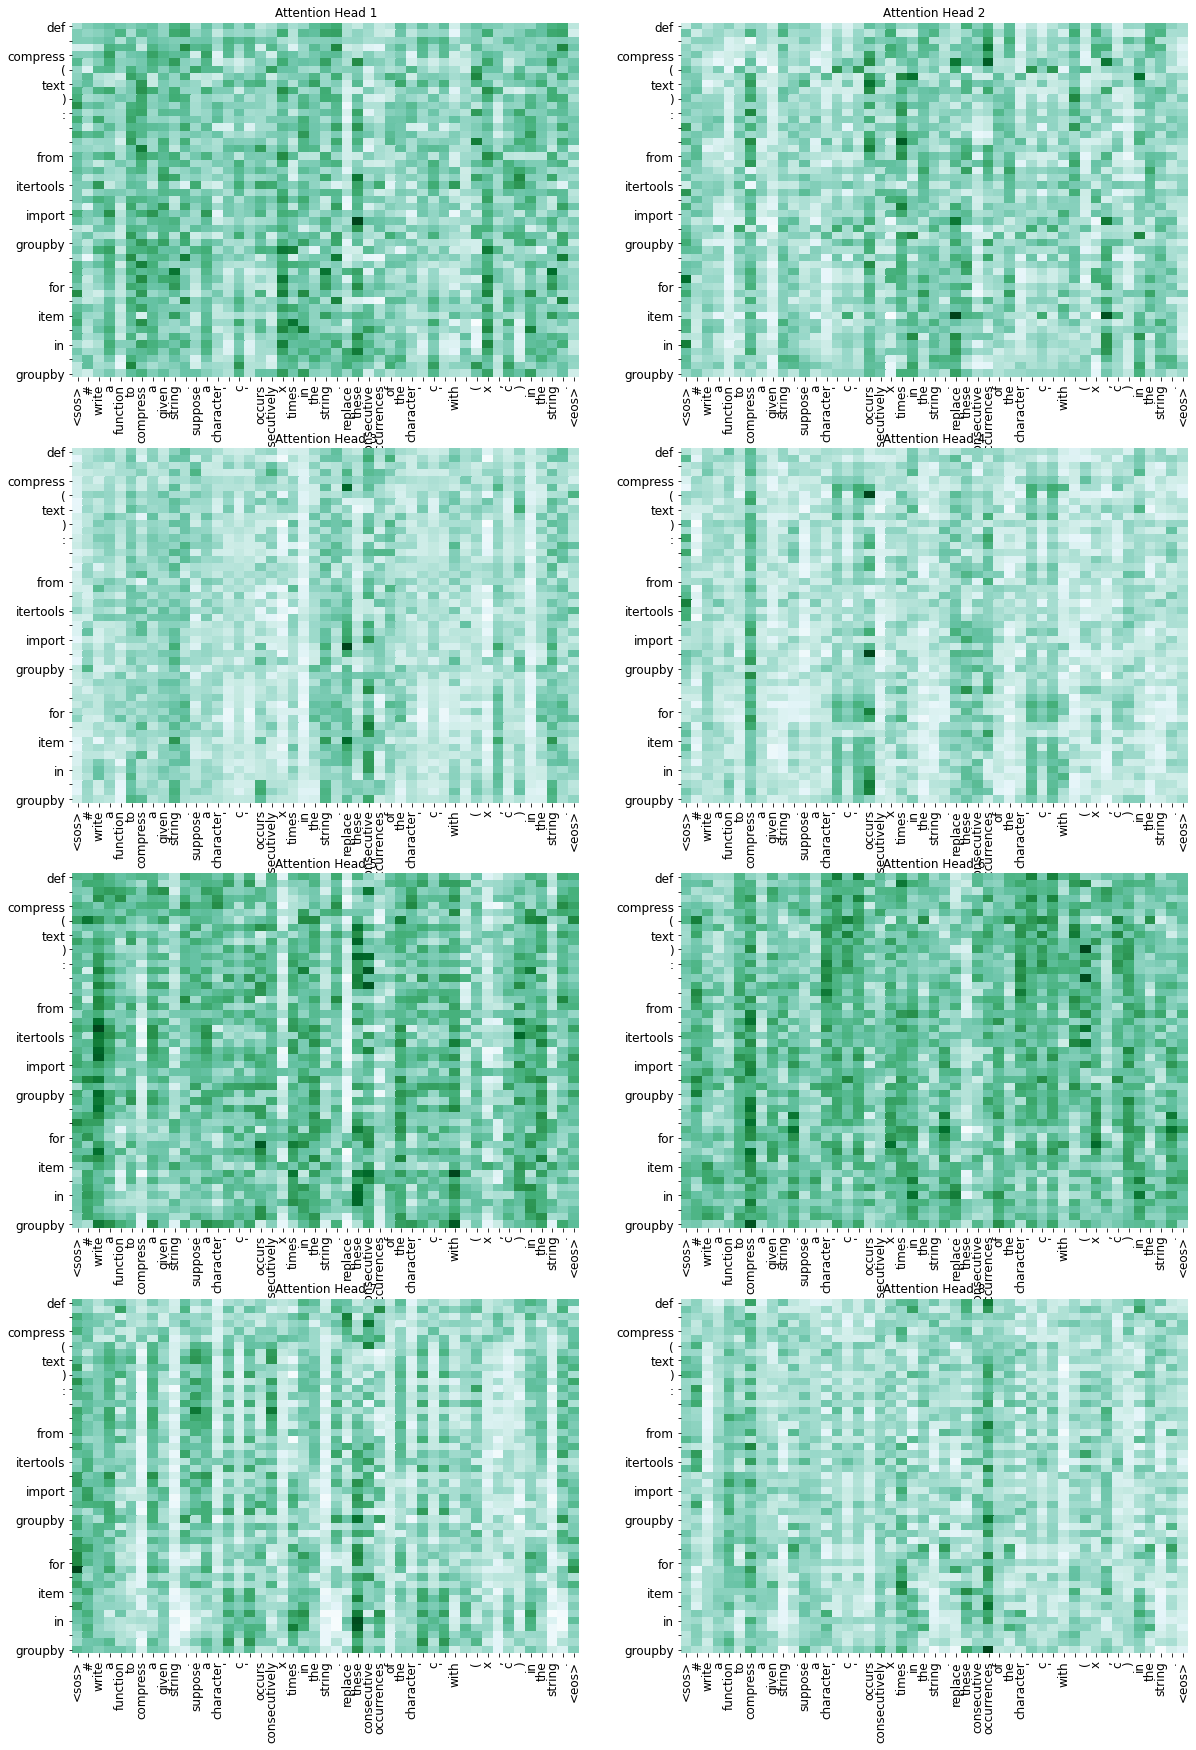

In [266]:
# Example 15
print_output(58, test_data, (20, 30), 'BuGn')

Prompt : write a program to print count of number of unique matching characters in a pair of strings


Target Source Code :
str1="ababccd12@"
str2="bb123cca1@"

matched_chars = set(str1) & set(str2) 
print("No. of matching characters are : " + str(len(matched_chars)) )



Predicted Source Code :
str1="ababccd12@"
str2="bb123cca1@"

matched_chars = set(str1) & set(str2) 
print("No. of matching characters are : " + str(len(matched_chars)))



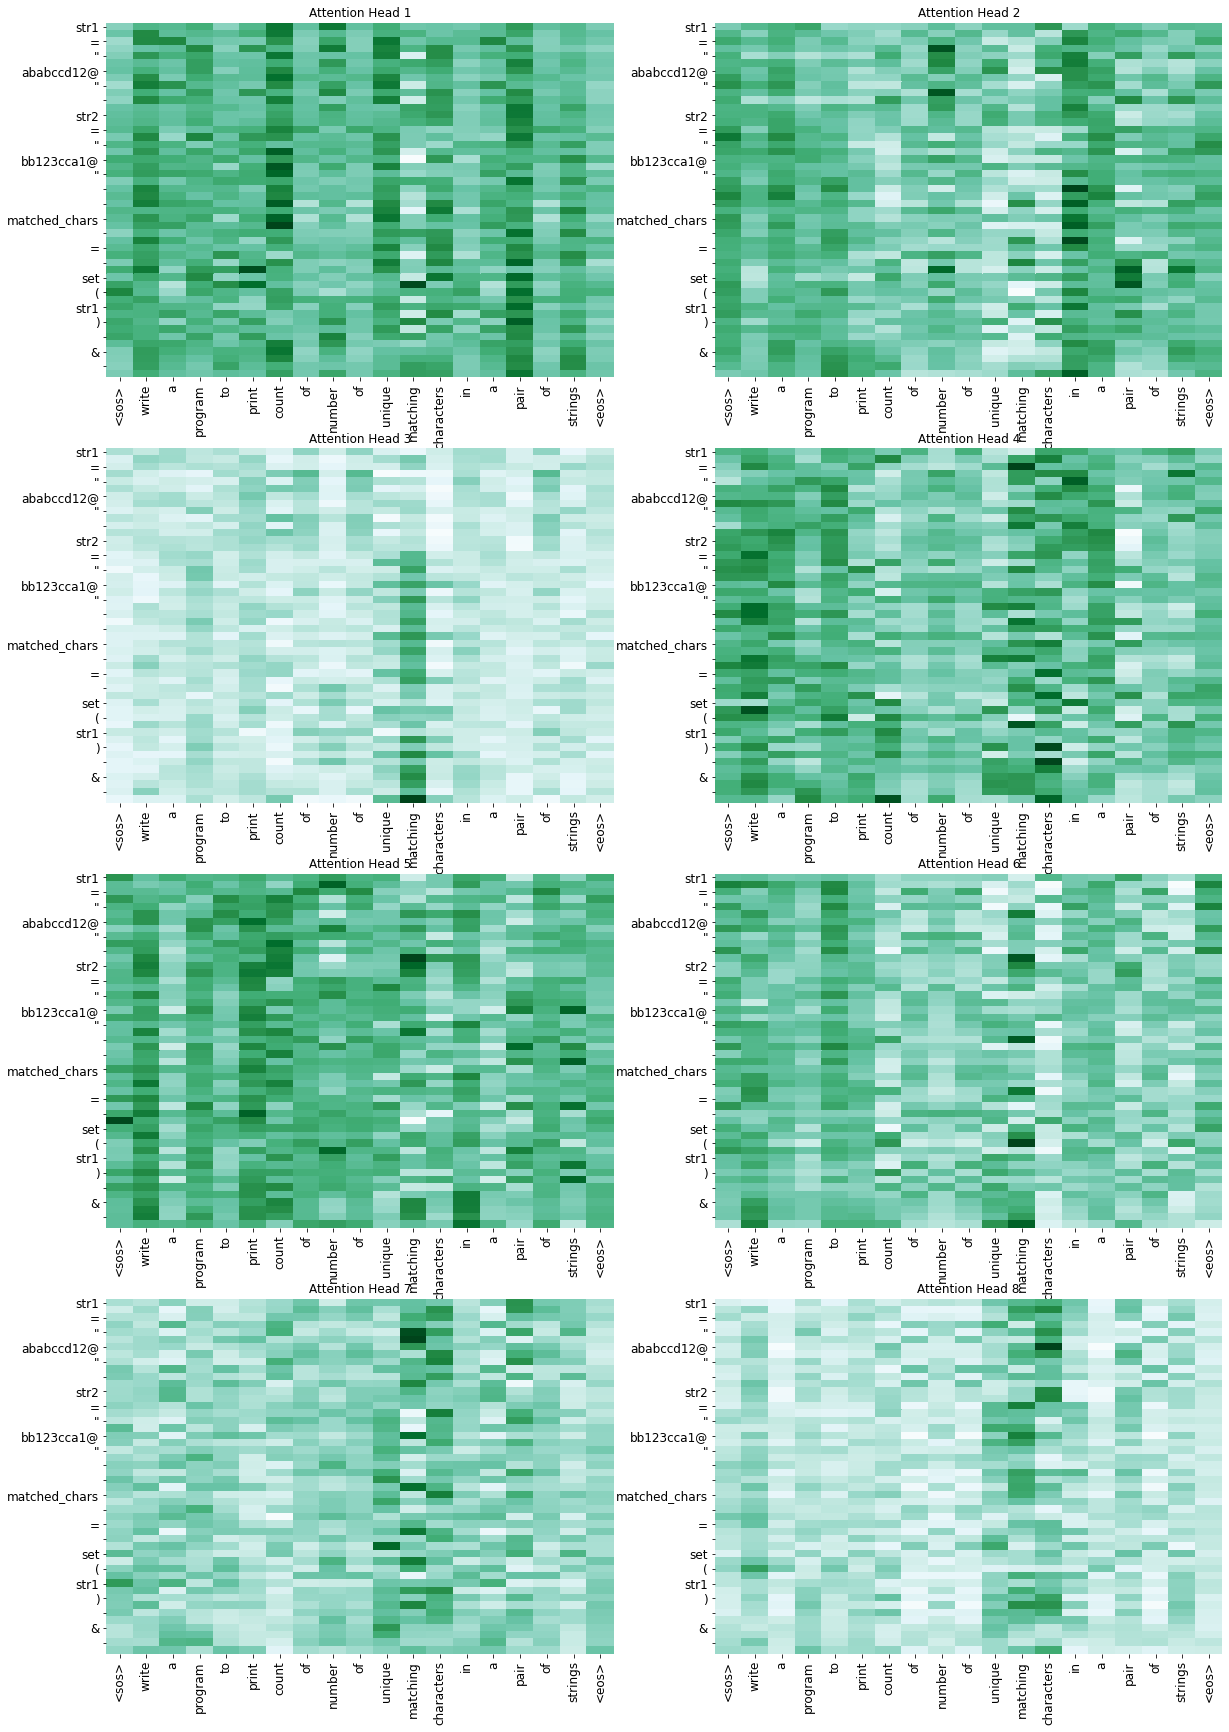

In [267]:
# Example 16
print_output(59, test_data, (20, 30), 'BuGn')

Prompt : write a function to return the area of a square


Target Source Code :
def cal_area_square(side):
    return side**2



Predicted Source Code :
def cal_area_square(side):
    return side**2



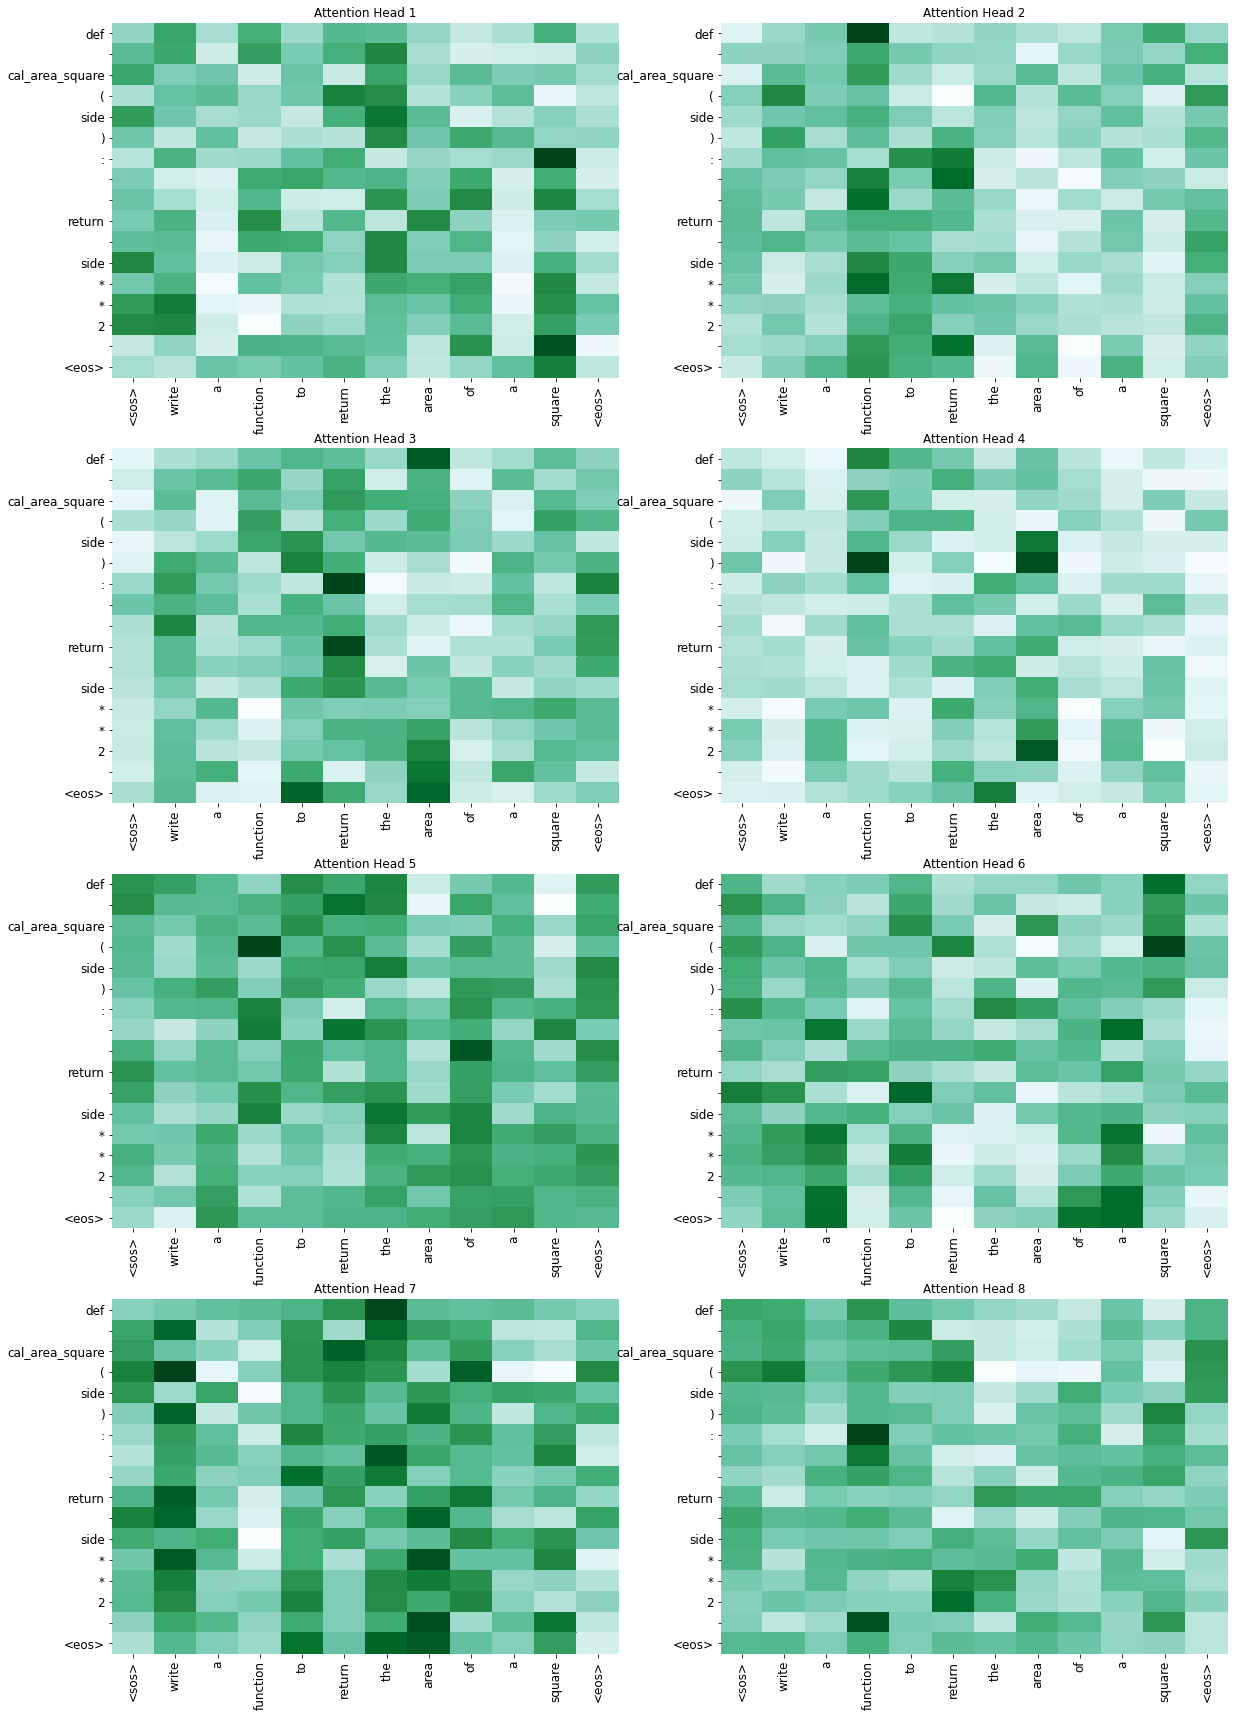

In [268]:
# Example 17
print_output(61, test_data, (20, 30), 'BuGn')

Prompt : write a python function to check if a given string is an anagram of another given string .


Target Source Code :
def is_anagram(str1, str2):
    list_str1 = list(str1)
    list_str1.sort()
    list_str2 = list(str2)
    list_str2.sort()

    return (list_str1 == list_str2)



Predicted Source Code :
def is_anagram(str1, str2):
    list_str1 = list(str1)
    list_str2.sort()
    list_str2 = list(str2)
    return (list_str1 == list_str2)



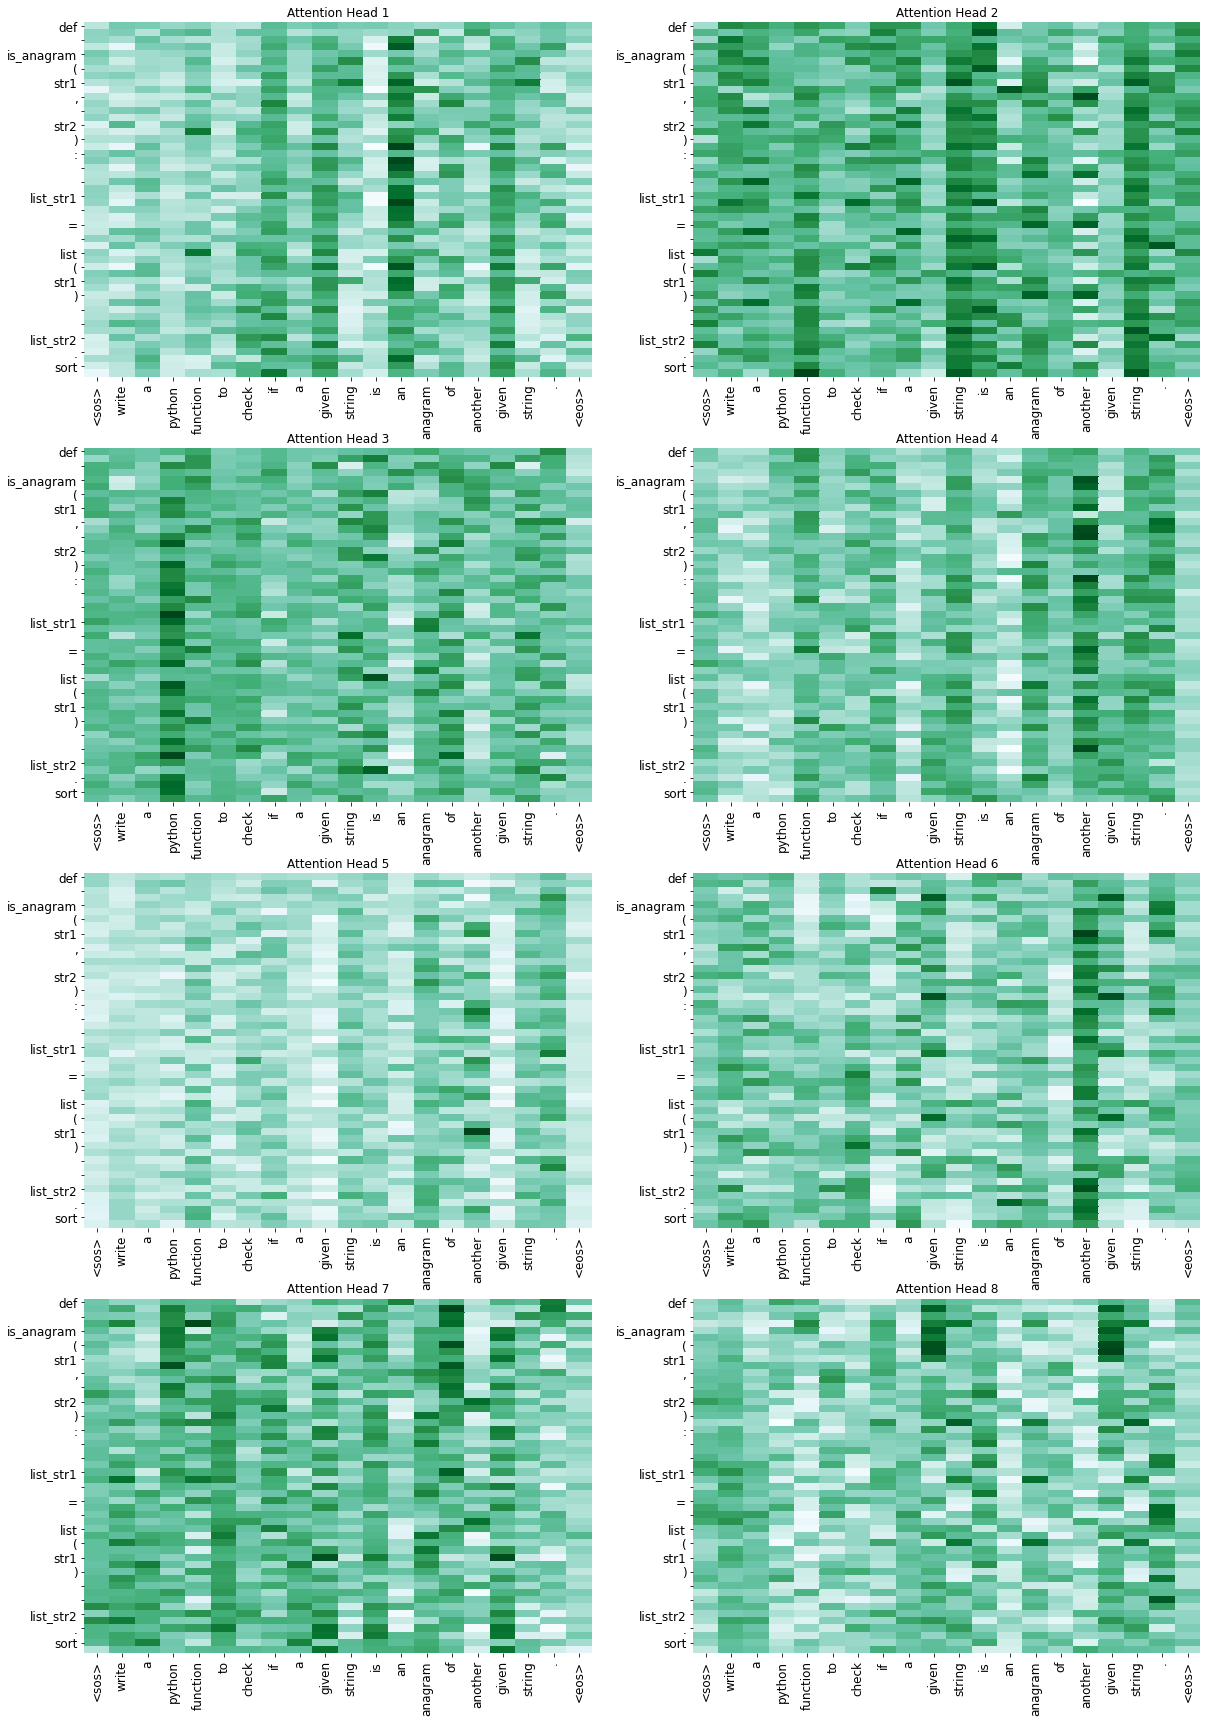

In [269]:
# Example 18
print_output(64, test_data, (20, 30), 'BuGn')

Prompt : to get a random element from an array in python


Target Source Code :
import random
list_ = [1,2,3,4]
random.choice(list_)



Predicted Source Code :
import random

mylist = random.choice([1,2,3,4,5])



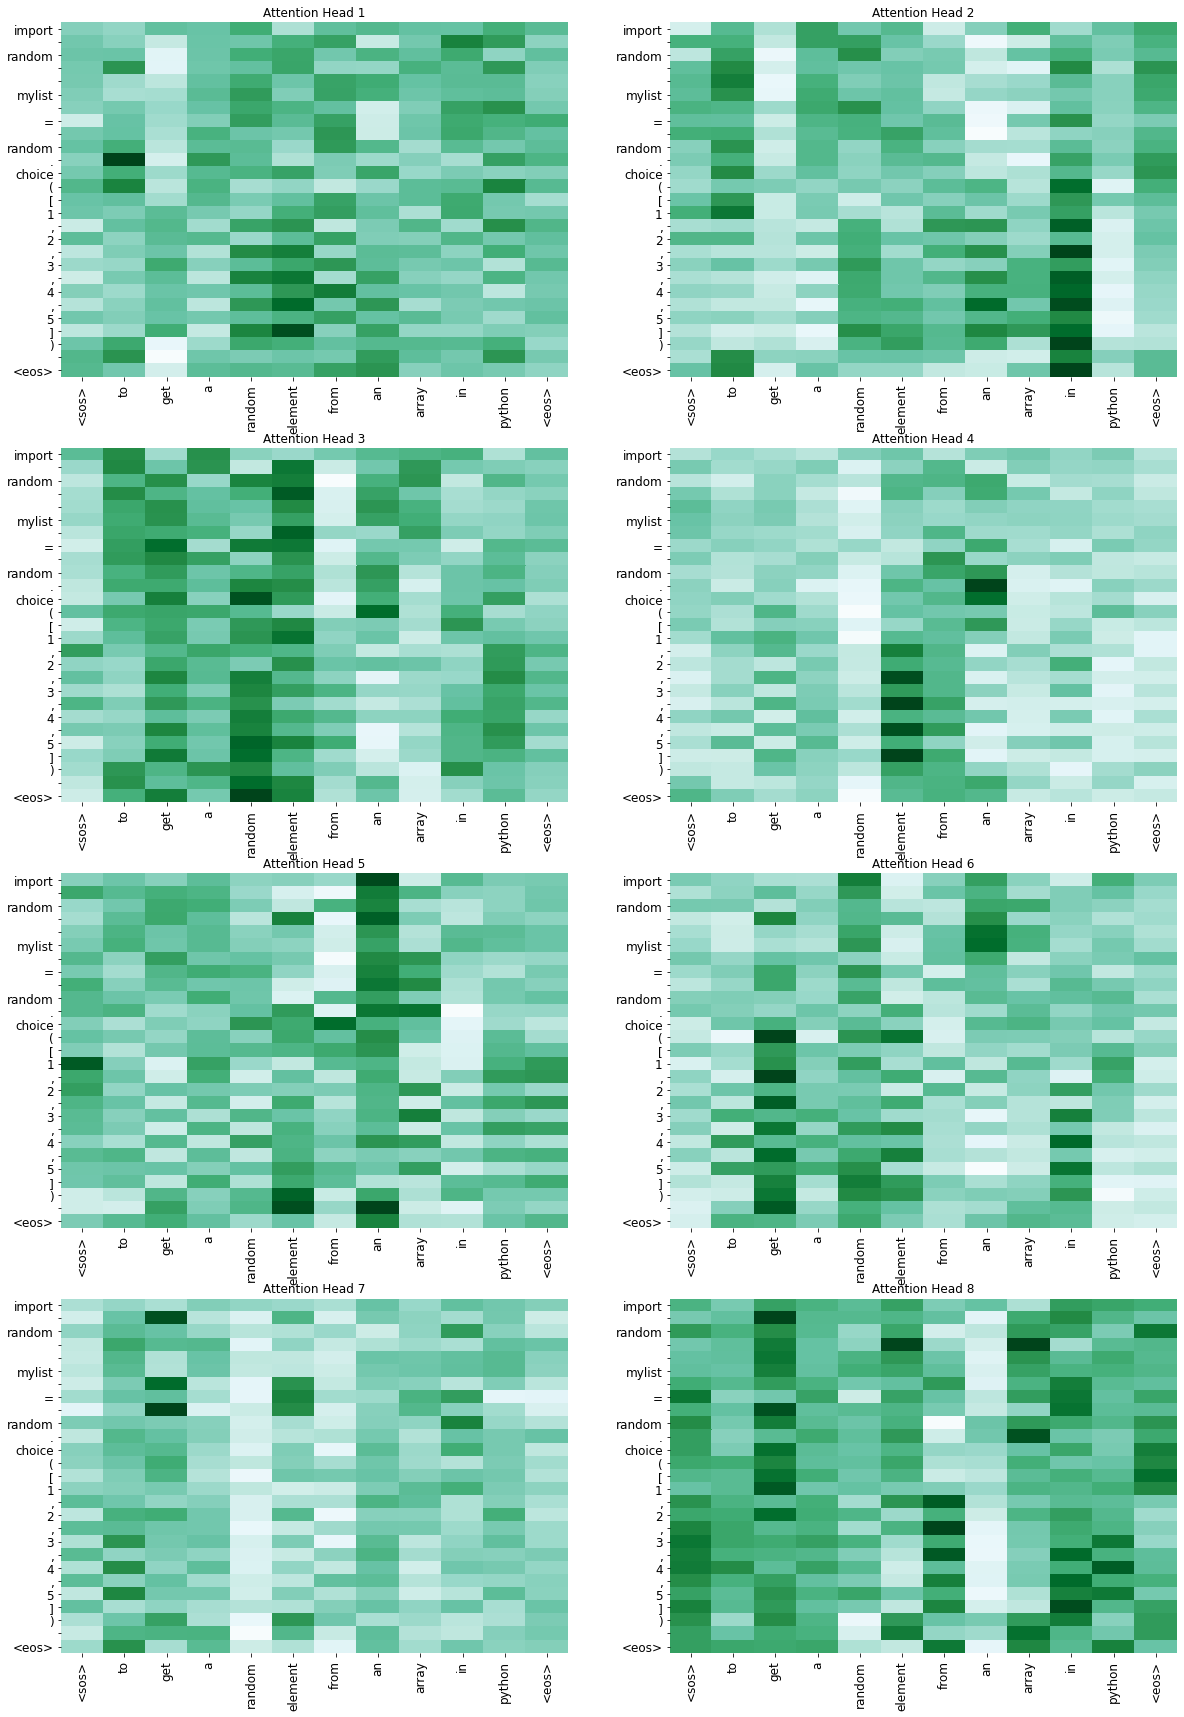

In [270]:
# Example 19
print_output(67, test_data, (20, 30), 'BuGn')

Prompt : write a function to return the perimeter of a square


Target Source Code :
def cal_perimeter_square(side):
    return 4*side



Predicted Source Code :
def cal_perimeter_square(side):
    return side**2



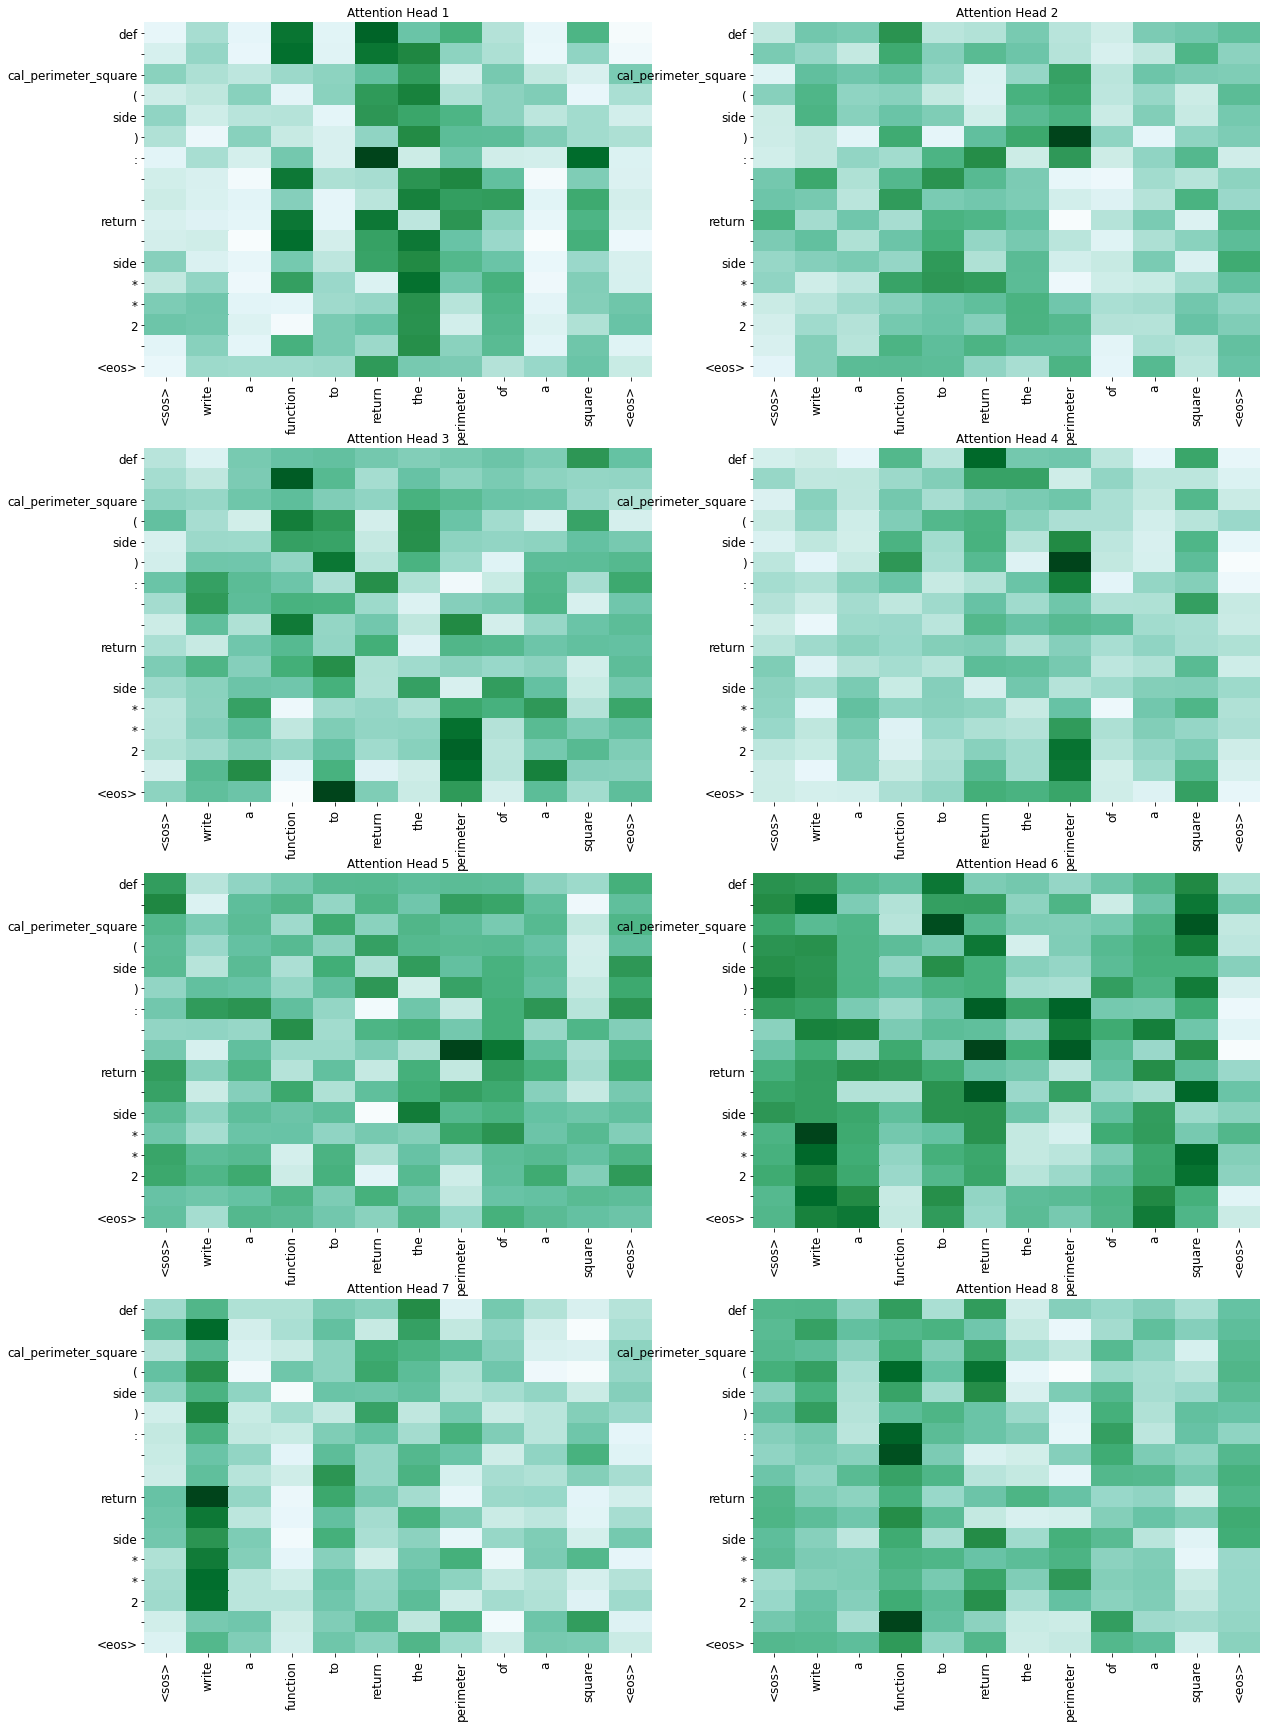

In [271]:
# Example 20
print_output(68, test_data, (20, 30), 'BuGn')

Prompt : write a python function that returns the input list sorted in descending order


Target Source Code :
def sort_descending(list_to_be_sorted):
    return sorted(list_to_be_sorted, reverse=True)



Predicted Source Code :
def descending_sort(list_to_be_sorted):
    sorted(list_to_be_sorted, reverse=True)



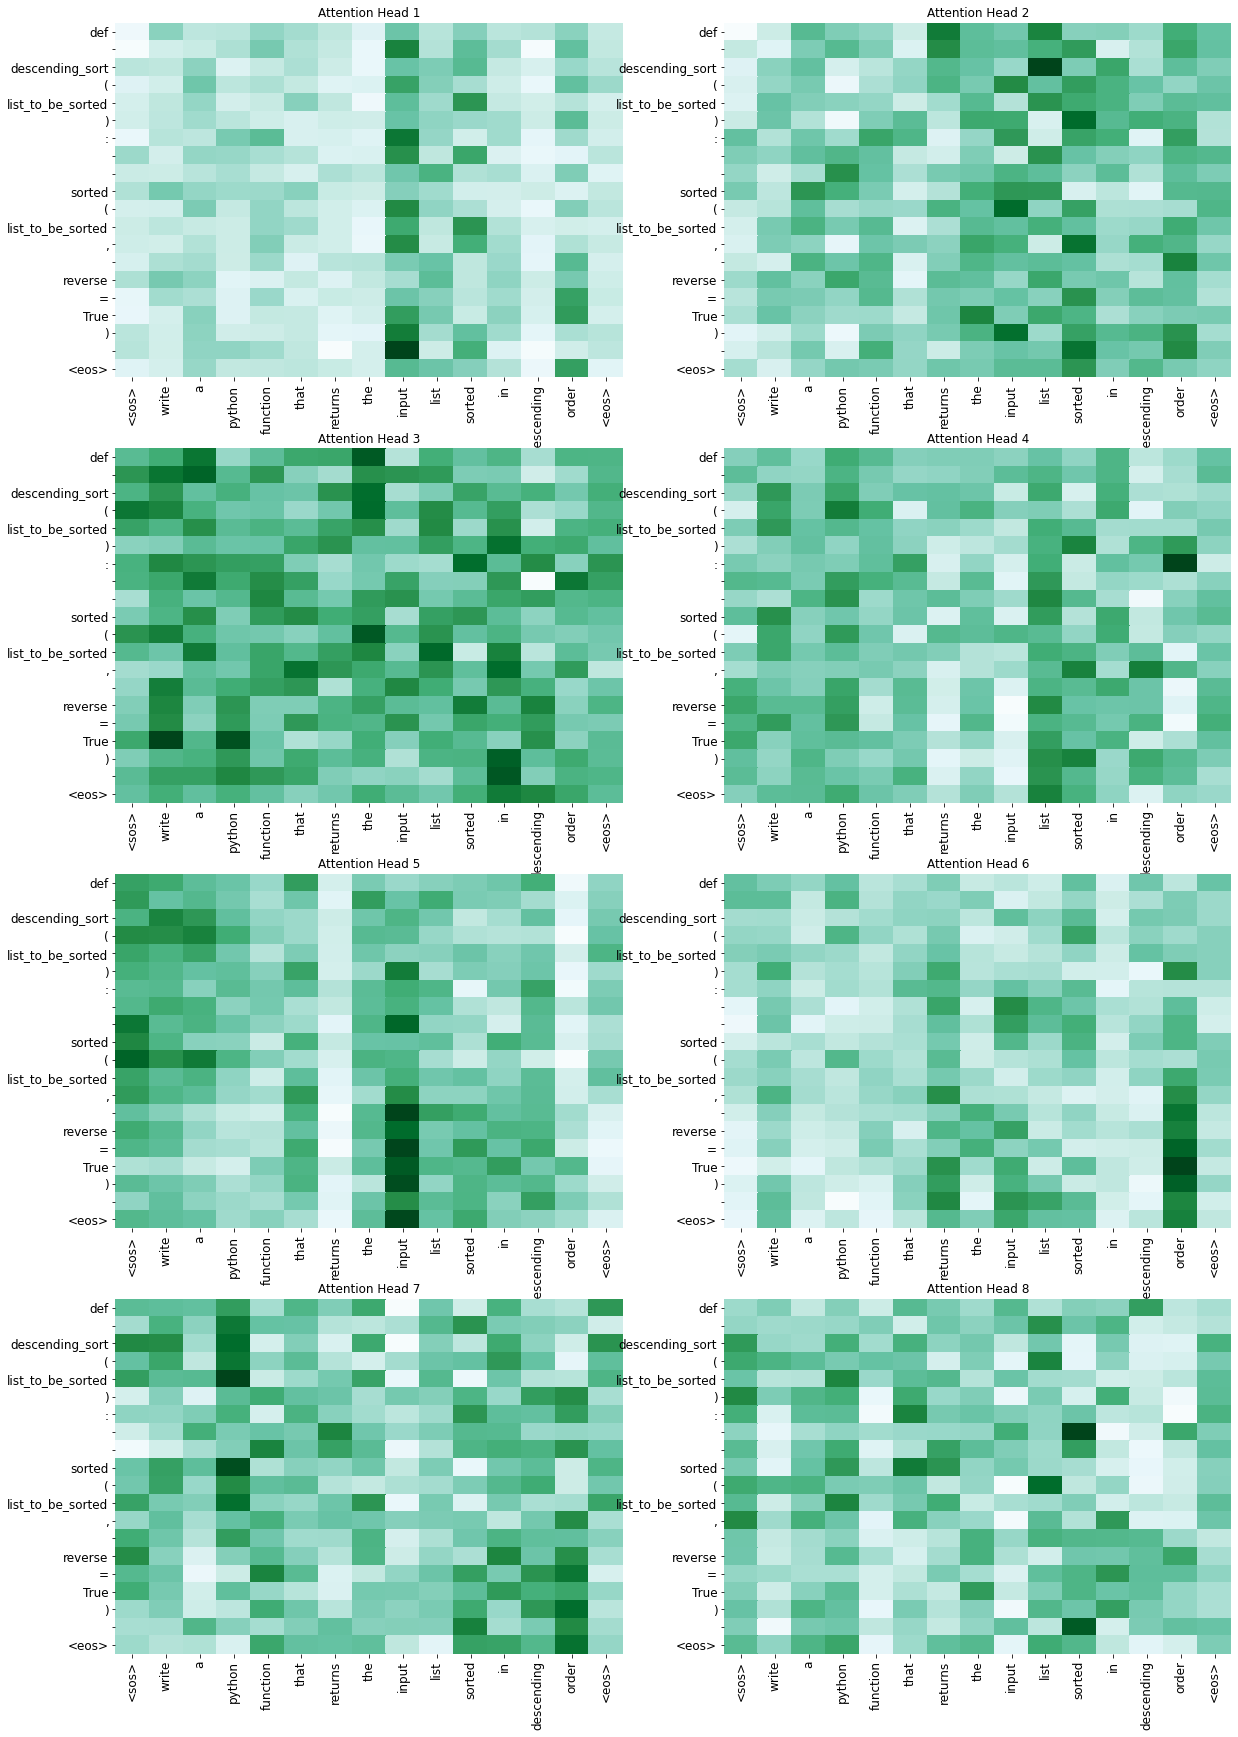

In [272]:
# Example 21
print_output(69, test_data, (20, 30), 'BuGn')

Prompt : write a python program to convert uppercase string to lower


Target Source Code :
a = 'STRING'
print(f'convert lowercase to uppercase:{a.lower()}')



Predicted Source Code :
string = "Hello World"
string = string.lower()
print('a')



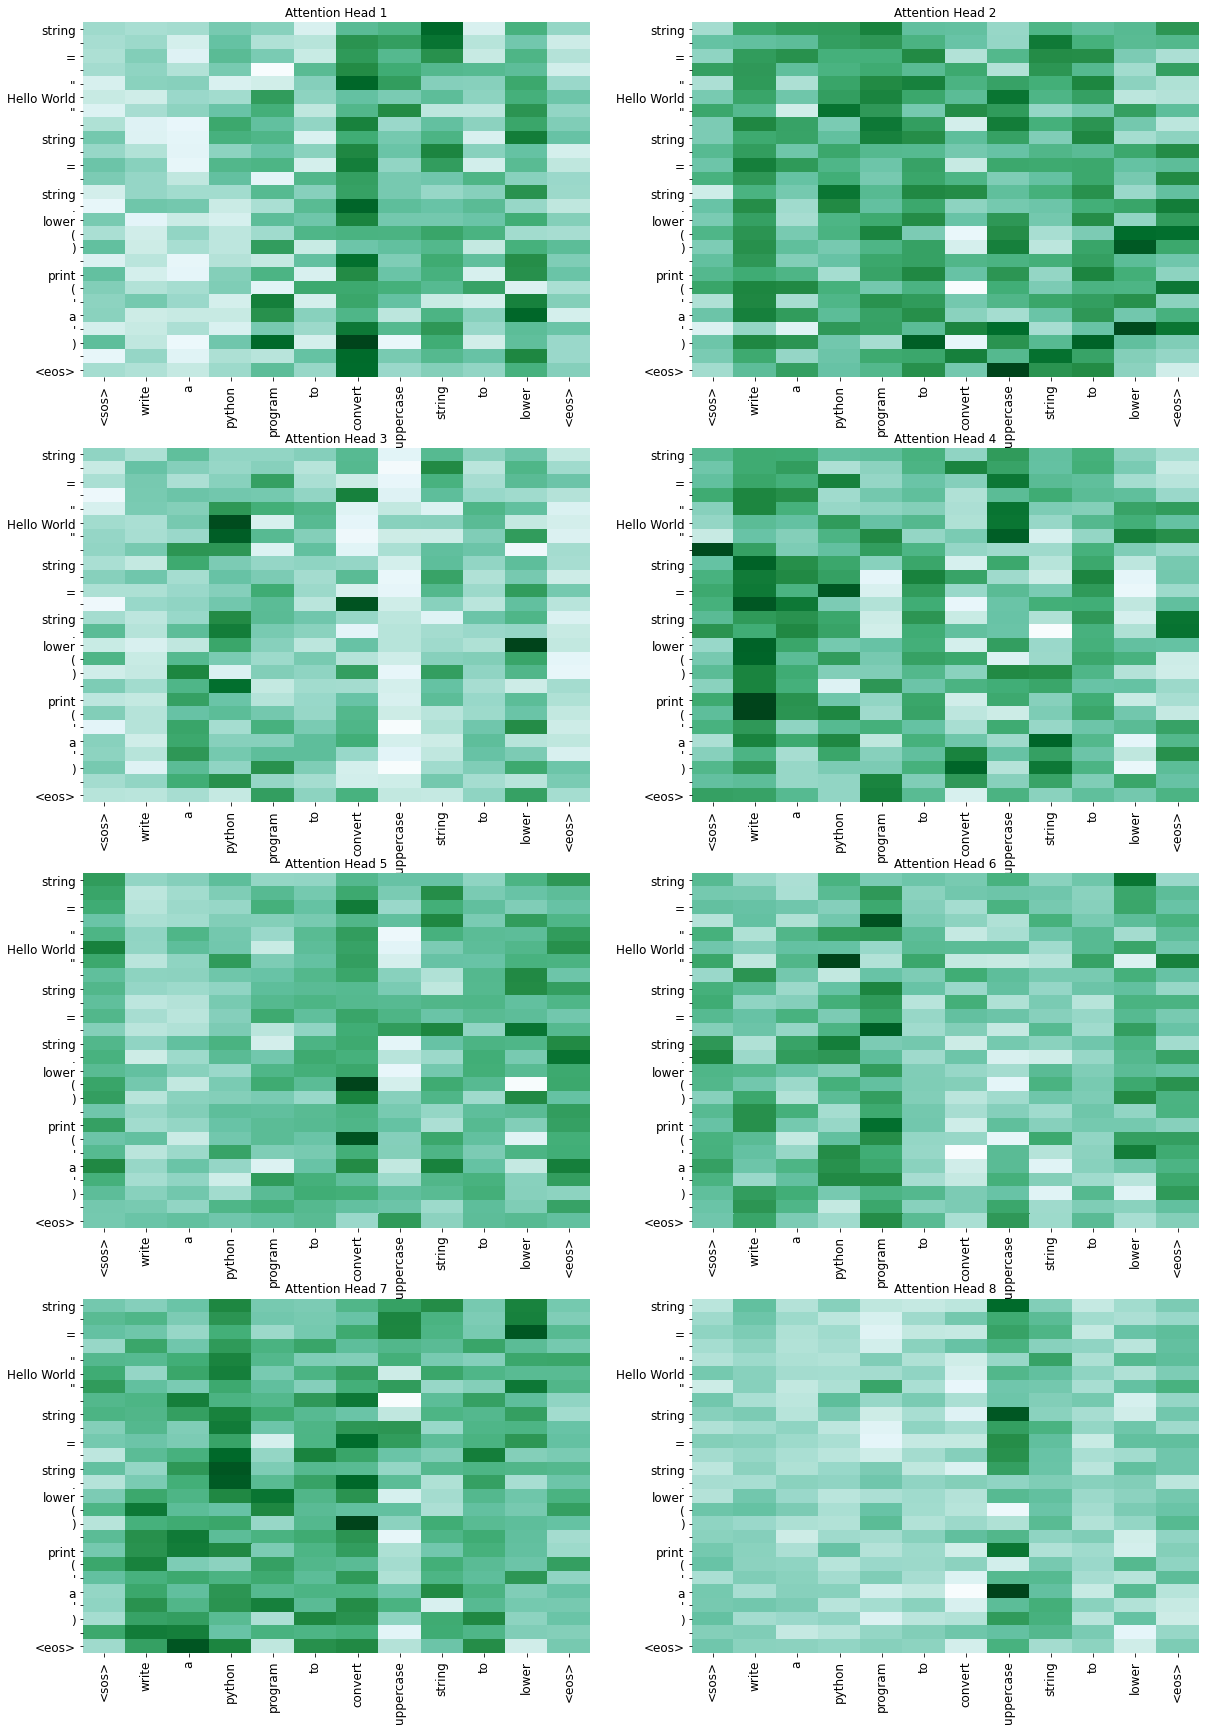

In [273]:
# Example 22
print_output(72, test_data, (20, 30), 'BuGn')

Prompt : write a python function that returns the input list sorted in ascending order


Target Source Code :
def sort_ascending(list_to_be_sorted):
    return sorted(list_to_be_sorted)



Predicted Source Code :
def reverse(list_to_be_sorted):
    return sorted(list_to_be_sorted)



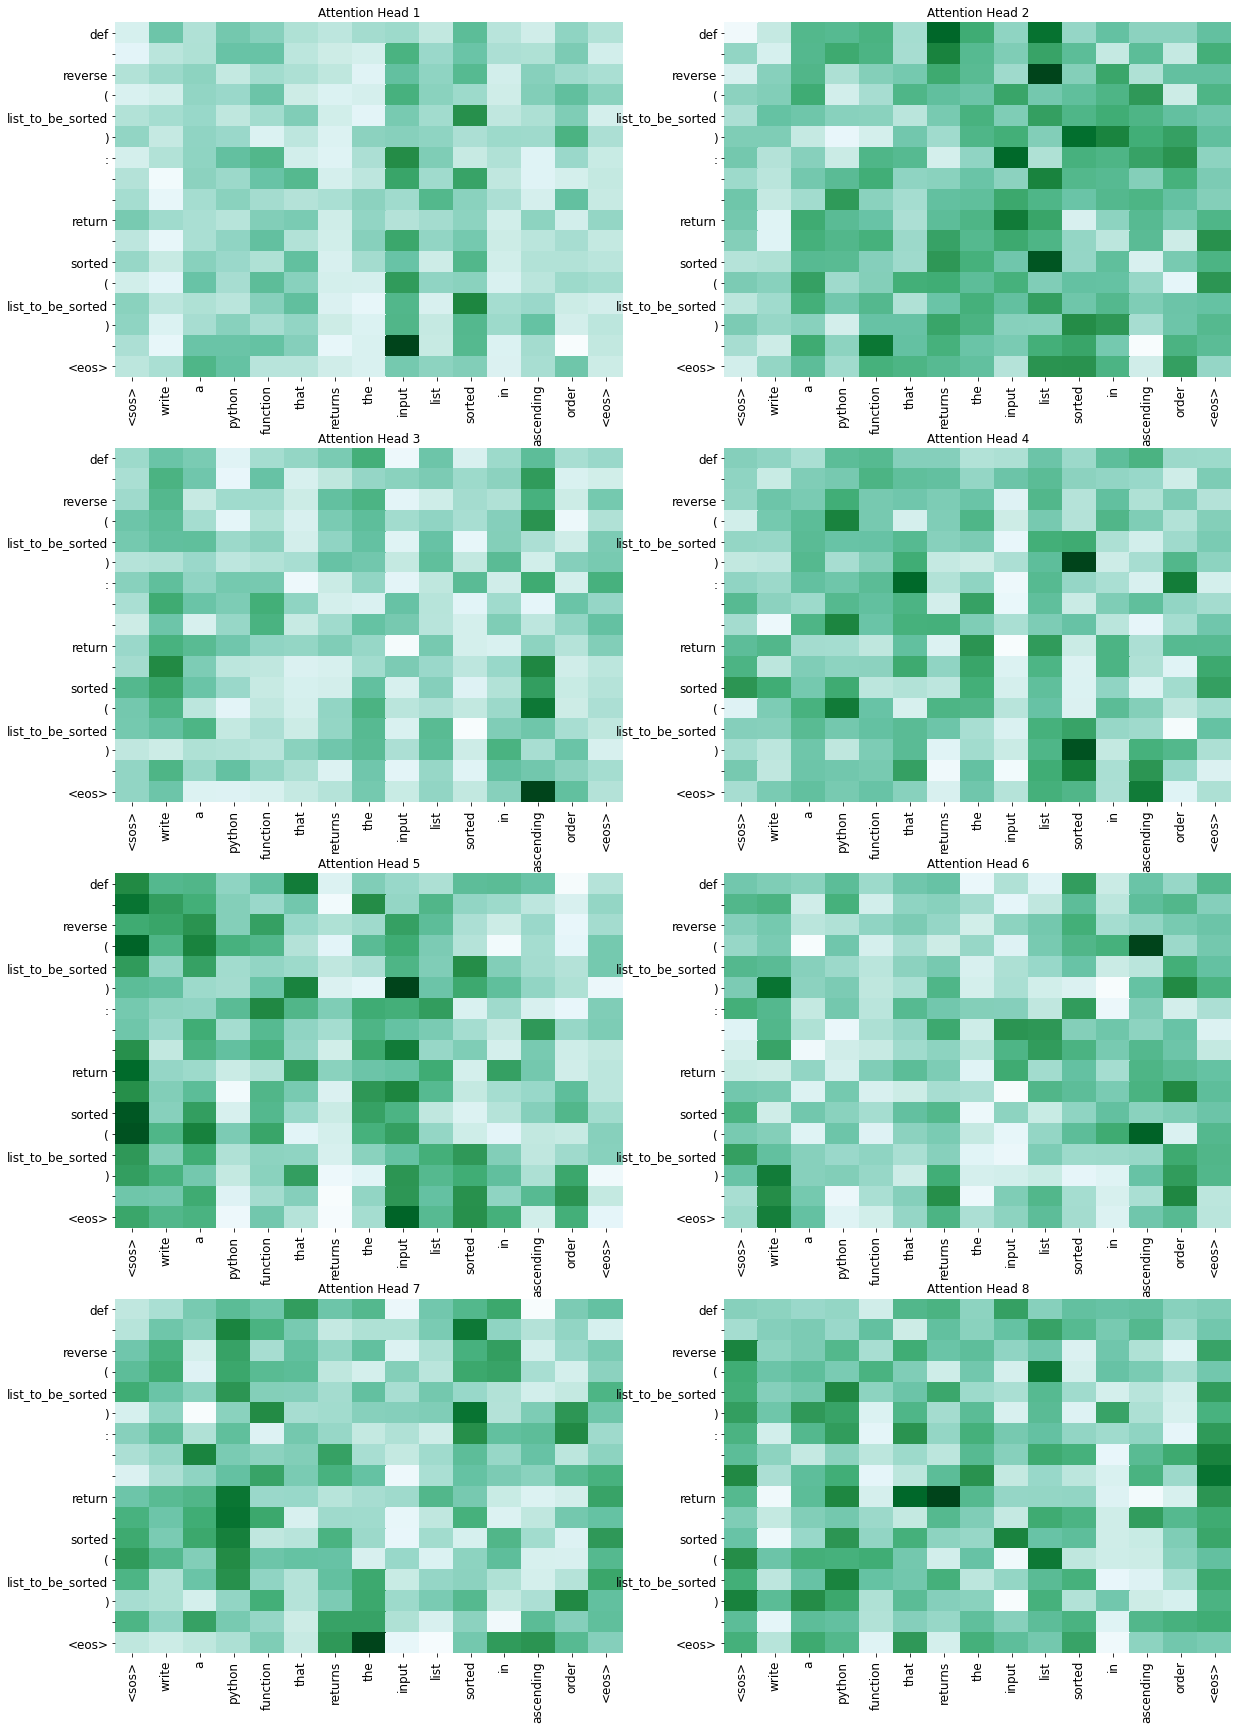

In [274]:
# Example 23
print_output(82, test_data, (20, 30), 'BuGn')

Prompt : write a python program to print the table of input integer


Target Source Code :
num = int(input("Please enter a number "))
for a in range(1,11):
    print(num , 'x' , a , '=' ,num*a)



Predicted Source Code :
num = int(input("Input a value: "))
for i in range(1,11):
   print(num,'x'=',num*i)



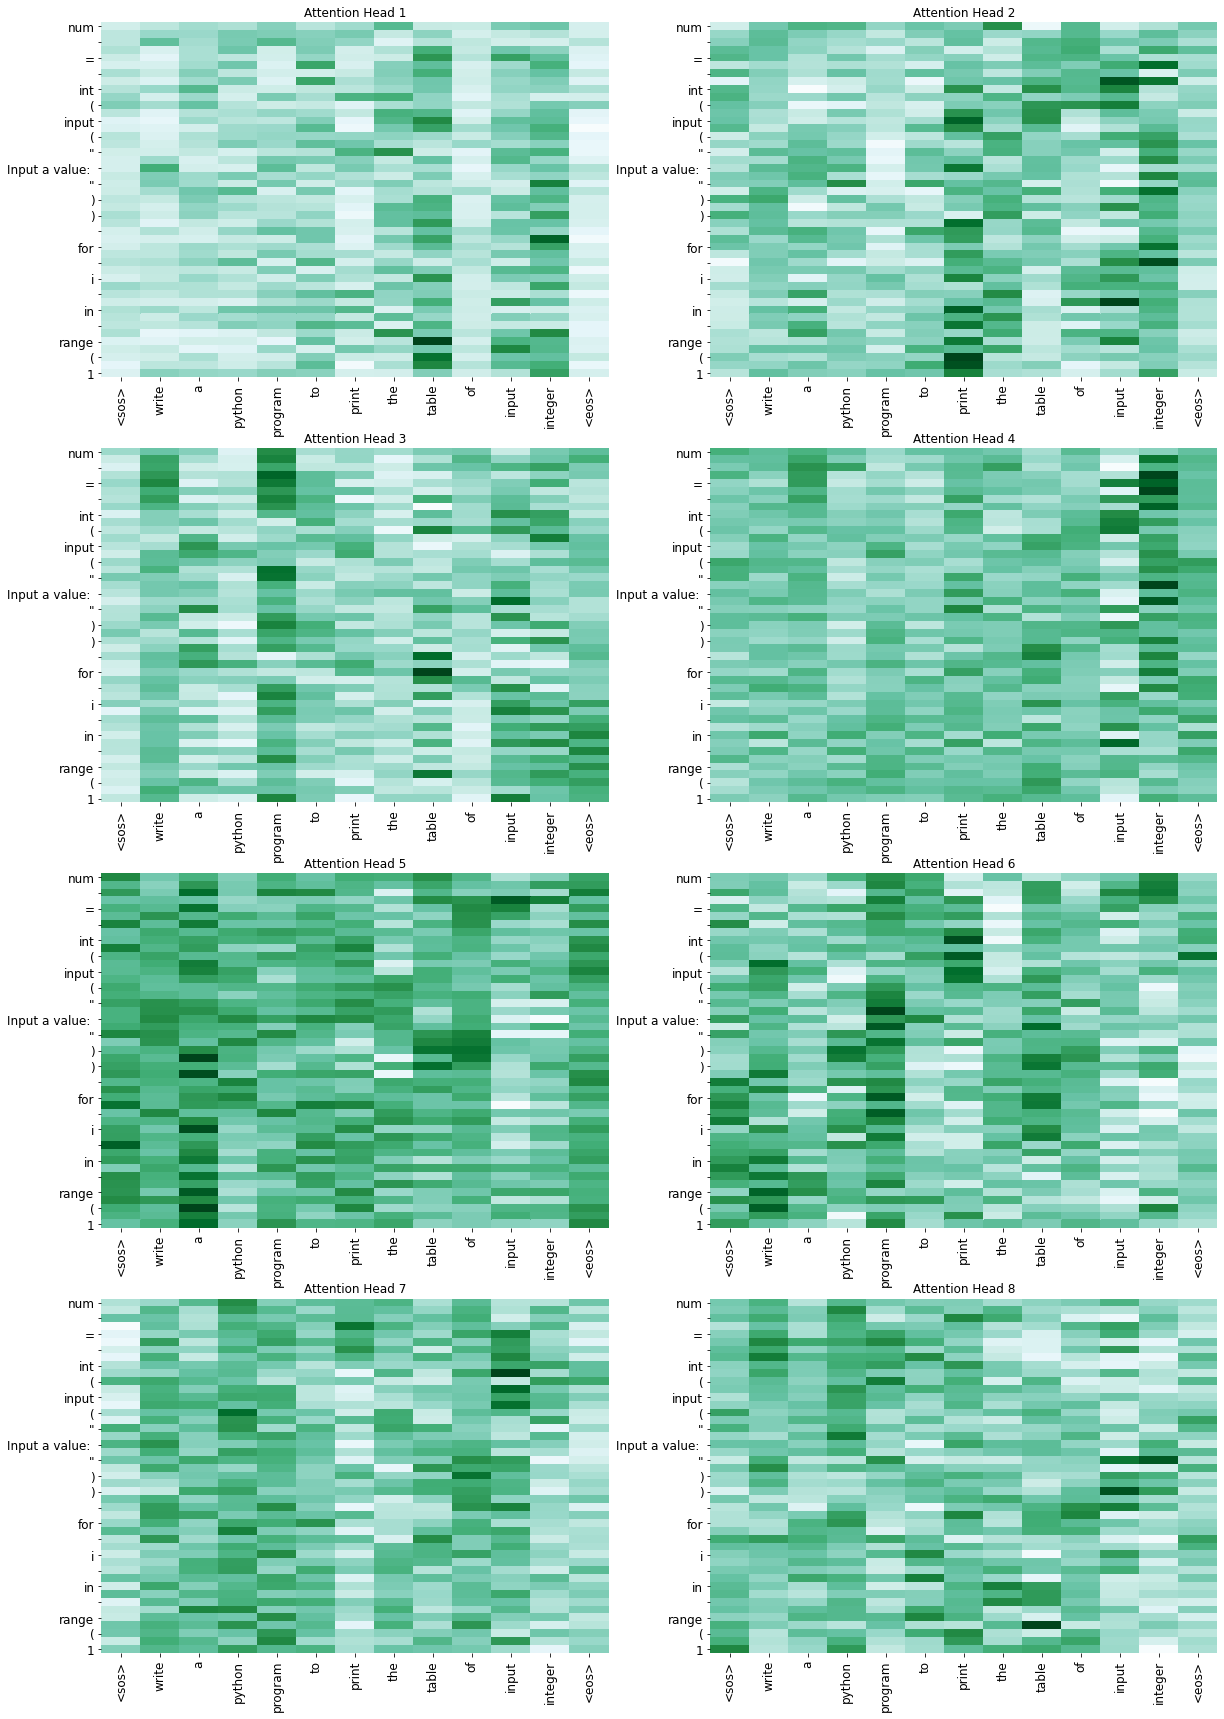

In [275]:
# Example 24
print_output(93, test_data, (20, 30), 'BuGn')

Prompt : write a python program to tokenise a string into words and print them


Target Source Code :
string = 'the sun is shining'

words = string.split()
print(words)



Predicted Source Code :
sentence = 'the quick brown fox'
print(sentence.split(' '))



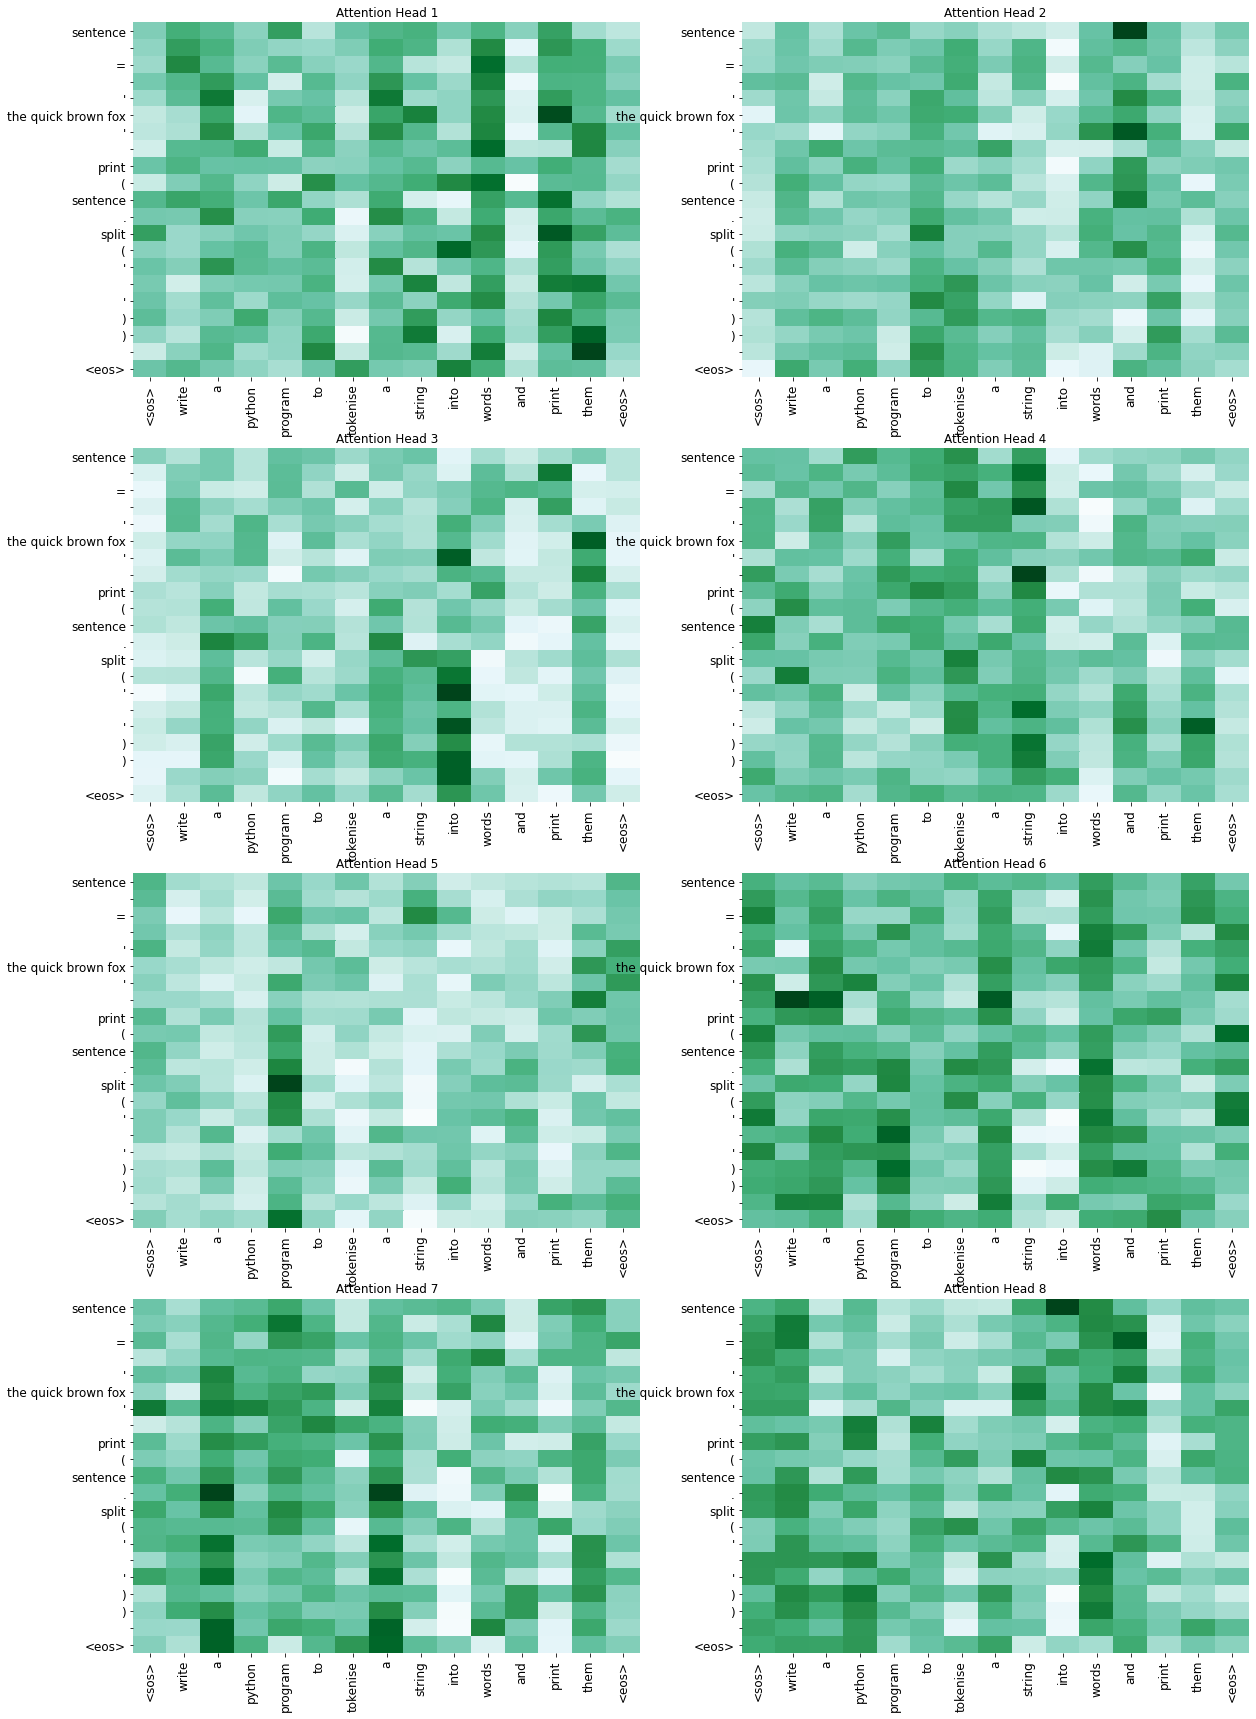

In [276]:
# Example 25
print_output(111, test_data, (20, 30), 'BuGn')